# Problem Description

Note: All information found here is fictitious.
The company is planning to renovate all of its stores and needs an estimate of each store's budget to make the  best possible decisions in the renovation process. That's why we got the job done by the CFO to predict how  much their stores will have sold by the end of the next six weeks. We received data on each of the 1,115 stores and their characteristics, along with the daily sales volume over a two-and-a-half year interval.

# Business Problem Question

- How much will each store sell in the next six weeks?

# Solution Planning

Let's build a machine learning model that predicts the sales volume for each of the stores over a period of 6 weeks. 
The solution will be accessed remotely through the Telegram Messenger app, as soon as a message containing a valid store number 
is sent, a chatbot will respond with the corresponding forecast.

# Project Walkthrough

- Loading Data - all data is stored in csv files ( source of files: https://www.kaggle.com/c/rossmann-store-sales/data)

- Data Description - check datatypes, null values and initial statistics.

- Feature Engineering - create business hypotheses and new features based on the original features.

- Filtering Variables - drop any non-helpful information.

- Exploratory Data Analysis - dig deep into data to gather all possible information and attempt to validate our hypotheses

- Data Preparation - get our data ready for machine learning models.

- Feature Selection - choose the most relevant features.

- Machine Learning Modeling - train and compare several models and select the best performing ones.

- Hyperparameter Fine Tuning - find optimal parameters for selected models and settle on the best one.

- Metrics Comprehension - translating the results obtained by the model into business performance.

- Model Deploy - make our model available to the company.

# Imports

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import math
import inflection
import warnings
import datetime
import xgboost as xgb
import pickle
import requests
import json

from matplotlib           import pyplot as plt
from IPython.core.display import HTML
from IPython.display      import Image
from scipy                import stats as ss
from boruta               import BorutaPy

from sklearn.preprocessing   import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.ensemble        import RandomForestRegressor
from sklearn.metrics         import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.linear_model    import LinearRegression, Lasso
from sklearn.model_selection import RandomizedSearchCV

warnings.filterwarnings("ignore")

# Helper Functions

In [5]:
#Numerical Data descriptive statistics
def desc_num (num_att):

    #measures of central tendency: mean and median
    #mean
    ct1 = num_att.apply( lambda x: np.mean(x) )
    #median
    ct2 = num_att.apply( lambda x: np.median(x) )

    #measures of spread: min, max, range and standard deviation
    #min
    d1 = num_att.apply( lambda x: np.min(x) )
    #max
    d2 = num_att.apply( lambda x: np.max(x) )
    #range
    d3 = num_att.apply( lambda x: np.max(x) - np.min(x) )
    #std
    d4 = num_att.apply( lambda x: np.std(x) )
    
    #measures of shape: skew and kurtosis
    #skew
    d5 = num_att.apply( lambda x: x.skew() )
    #kurtosis
    d6 = num_att.apply( lambda x: x.kurtosis() )

    num_df = pd.DataFrame( [ d1, d2, d3, ct1, ct2, d4, d5, d6] ).T.reset_index()
    num_df.columns = ['attribute', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis'] 
    return num_df

def cramer_v(x, y):
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
    
    kcorr = k- (k-1)**2/(n-1)
    rcorr = r- (r-1)**2/(n-1)
    
    return np.sqrt((chi2corr/n)/(min(kcorr-1, rcorr-1)))

def mean_percentage_error(y, yhat):
    return np.mean((y - yhat)/y)

def ml_error(model_name, y, yhat):
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))
    
    return pd.DataFrame({'Model Name': model_name,
                         'MAE': mae,
                         'MAPE': mape,
                         'RMSE': rmse}, index=[0])

def cross_validation( x_training, kfold, model_name, model, verbose=False ):
    mae_list = []
    mape_list = []
    rmse_list = []
    for k in reversed(range(1, kfold + 1)):
        
        if verbose:

            print('\nKFold Number: {}'.format(k))

        # start and end date for validation
        validation_start_day = x_training['date'].max() - datetime.timedelta(days=k*6*7)
        validation_end_day = x_training['date'].max() - datetime.timedelta(days=(k-1)*6*7)

        # filtering dataset
        training = x_training[x_training['date'] < validation_start_day]
        validation = x_training[(x_training['date'] >= validation_start_day) & (x_training['date'] <= validation_end_day)]

        # training and validation dataset
        # training
        xtraining = training.drop(['date', 'sales'], axis=1)
        ytraining = training['sales']

        # validation
        xvalidation = validation.drop(['date', 'sales'], axis=1)
        yvalidation = validation['sales']

        # model
        m = model.fit(xtraining, ytraining)

        # prediction
        yhat = m.predict(xvalidation)



        # perfomace
        m_result = ml_error(model_name, np.expm1(yvalidation), np.expm1(yhat))

        # store perfomace of each kfold interation
        mae_list.append(m_result['MAE'])
        mape_list.append(m_result['MAPE'])
        rmse_list.append(m_result['RMSE'])

    return pd.DataFrame( {'Model Name': model_name,
                              'MAE CV': np.round( np.mean( mae_list ), 2 ).astype(str ) + ' +/- ' + np.round(np.std(mae_list), 2).astype(str),
                              'MAPE CV': np.round( np.mean( mape_list ), 2 ).astype( str ) + ' +/- ' + np.round(np.std(mape_list), 2).astype(str),
                              'RMSE CV': np.round( np.mean( rmse_list ), 2 ).astype( str ) + ' +/- ' + np.round(np.std(rmse_list), 2).astype(str)}, index=[0])

def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

In [6]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


# Loading Data

In [7]:
df_sales_raw = pd.read_csv('data/train.csv', low_memory=False)
df_store_raw = pd.read_csv('data/store.csv')

df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

### Column Description:

Id - an Id that represents a (Store, Date) duple within the test set

Store - a unique Id for each store

Sales - the turnover for any given day (this is what you are predicting)

Customers - the number of customers on a given day

Open - an indicator for whether the store was open: 0 = closed, 1 = open

StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None

SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools

StoreType - differentiates between 4 different store models: a, b, c, d

Assortment - describes an assortment level: a = basic, b = extra, c = extended

CompetitionDistance - distance in meters to the nearest competitor store

CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened

Promo - indicates whether a store is running a promo on that day

Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating

Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2

PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

# Data Description

In [8]:
df1 = df_raw.copy()

## Rename Columns

In [9]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open',
            'Promo', 'StateHoliday', 'SchoolHoliday', 'StoreType', 
            'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth',
            'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
            'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore(x)

cols_new = list(map(snakecase, cols_old))

df1.columns = cols_new

## Data dimensions

In [10]:
df1.shape

(1017209, 18)

## Data Types

In [11]:
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## Check NaN

In [12]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## Fillout NaN

In [13]:
#competition_distance             
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

#competition_open_since_month 
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month 
                                                if math.isnan(x['competition_open_since_month']) 
                                                else x['competition_open_since_month'], axis=1)

#competition_open_since_year 
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year 
                                                if math.isnan(x['competition_open_since_year']) 
                                                else x['competition_open_since_year'], axis=1)

#promo2_since_week
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week 
                                                if math.isnan(x['promo2_since_week']) 
                                                else x['promo2_since_week'], axis=1)

#promo2_since_year
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year 
                                                if math.isnan(x['promo2_since_year']) 
                                                else x['promo2_since_year'], axis=1)

#promo_interval
month_map = {1:'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun',
             7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

df1['promo_interval'].fillna(0, inplace=True)

df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 
                                                             if x['promo_interval'] == 0 
                                                             else 1 
                                                             if x['month_map'] in x['promo_interval'].split(',')
                                                             else 0, axis=1)

In [14]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## Change Types

In [15]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype('int64')
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype('int64')
df1['promo2_since_week'] = df1['promo2_since_week'].astype('int64')
df1['promo2_since_year'] = df1['promo2_since_year'].astype('int64')

## Descriptive Statistical

In [16]:
num_att = df1.select_dtypes(include=['int64', 'float64'])
cat_att = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

### Numerical Attributes

In [17]:
num_df = desc_num(num_att)
num_df

,attribute,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


### Categorical Attributes

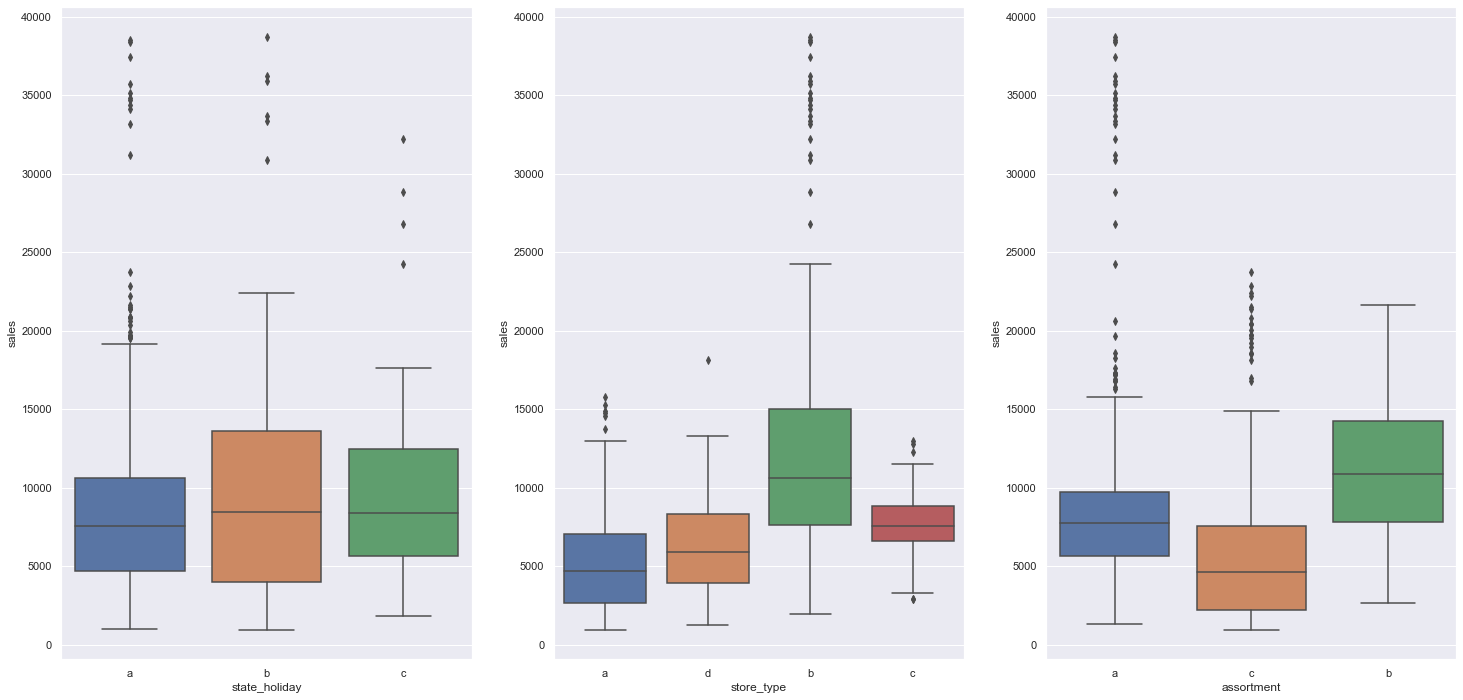

In [18]:
aux1 = df1[(df1['state_holiday'] != '0' ) & (df1['sales'] > 0)]

plt.subplot(1, 3, 1)
sns.boxplot(x='state_holiday', y='sales', data=aux1)

plt.subplot(1, 3, 2)
sns.boxplot(x='store_type', y='sales', data=aux1)

plt.subplot(1, 3, 3)
sns.boxplot(x='assortment', y='sales', data=aux1);

# Feature Engineering

In [19]:
df2 = df1.copy()

## Hypothesis Mind Map

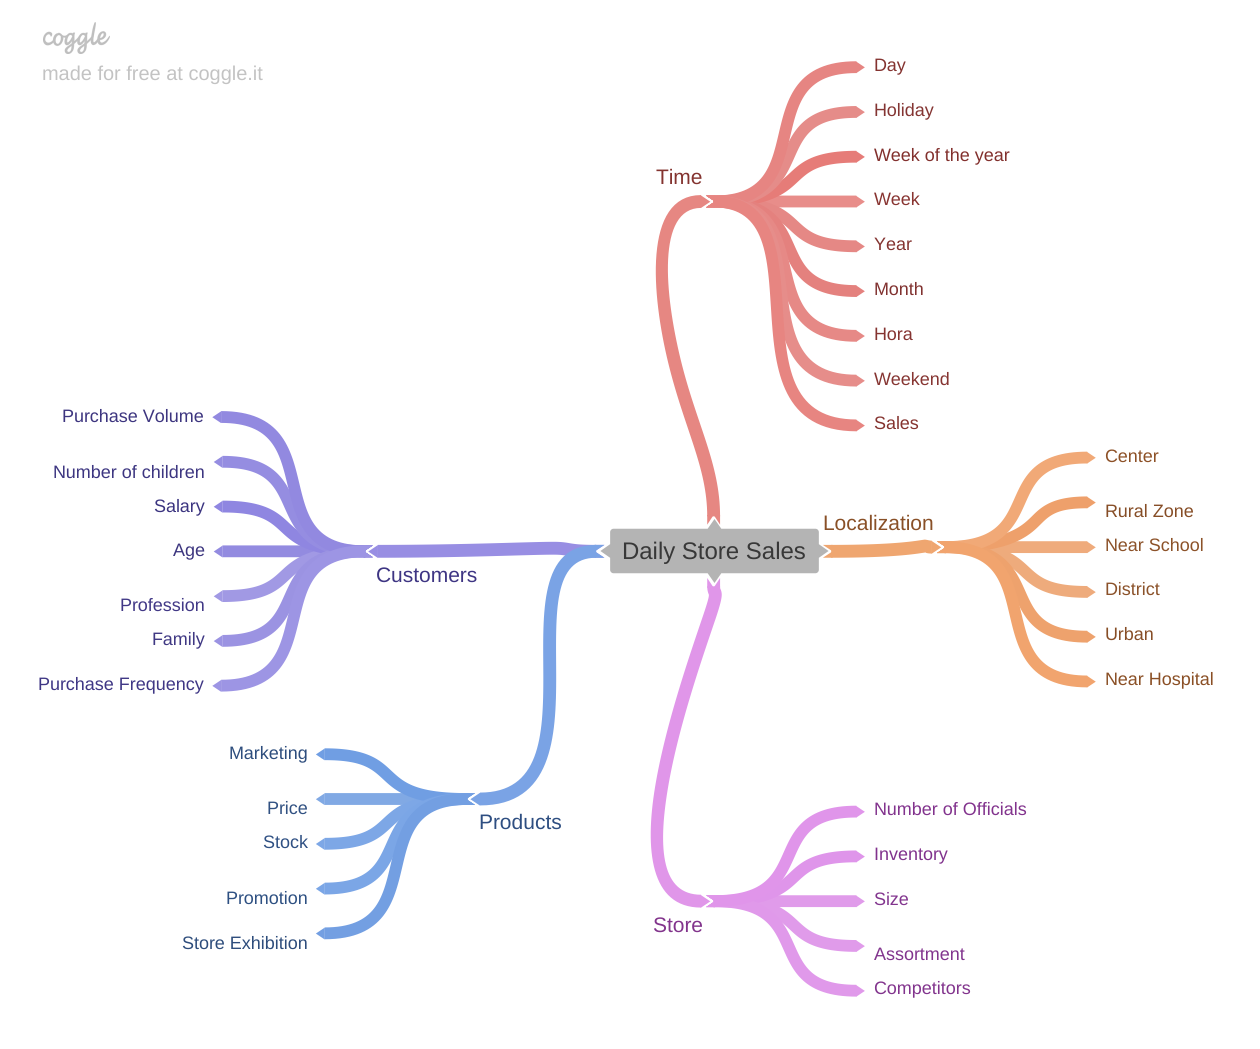

In [20]:
Image('img/Daily_Store_Sales.png')

## Creation of Hypotheses

### Store Hypotheses 

**1.** Stores with more employees should sell more.

**2.** Stores with greater inventory capacity should sell more.

**3.** Larger stores should sell more.

**4.** Stores with larger assortments should sell more.

**5.** Stores with closer competitors should sell less.

**6.** Stores with longer competitors should sell more.

### Store Product



**1.** Stores that invest more in Marketing should sell more.

**2.** Stores with more product exposure should sell more.

**3.** Stores with lower priced products should sell more.

**4.** Stores with more aggressive promotions (bigger discounts) should sell more.

**5.** Stores with longer running promotions should sell more.

**6.** Stores with more days of promotion should sell more.

**7.** Stores with more consecutive promotions should sell more.

### Store Time

**1.** Stores open during the Christmas holiday should sell more.

**2.** Stores should sell more over the years.

**3.** Stores should sell more in the second half of the year.

**4.** Stores should sell more after the 10th of each month.

**5.** Stores should sell less on weekends.

**6.** Stores should sell less during school holidays.

### Final List of Hypotheses

**1.** Stores with greater assortments should sell more.

**2.** Stores with closer competitors should sell less.

**3.** Stores with longer competitors should sell more.

**4.** Stores with longer active promotions should sell more.

**5.** Stores with more consecutive promotions should sell more.

**6.** Stores open during the Christmas holiday should sell more.

**7.** Stores should sell more over the years.

**8.** Stores should sell more in the second half of the year.

**9.** Stores should sell more after the 10th of each month.

**10.** Stores should sell less on weekends.

**11.** Stores should sell less during school holidays.

## Feature Engineering


In [21]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.weekofyear

# year week
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

# competition since
df2['competition_since'] = df2.apply( lambda x: datetime.datetime(year = x['competition_open_since_year'], 
                                                                  month = x['competition_open_since_month'], 
                                                                  day=1 ), axis=1 )


df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype('int64')

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )

df2['promo_since'] = df2['promo_since'].apply( lambda x: 
                                              datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - 
                                              datetime.timedelta( days=7 ) )

df2['promo_time_week'] = (( df2['date'] - df2['promo_since'] )/7).apply(lambda x: x.days ).astype('int64')

# assortment
df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' 
                                            else 'extra' 
                                            if x == 'b' 
                                            else 'extended' )

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' 
                                                  if x == 'a' 
                                                  else 'easter_holiday' 
                                                  if x == 'b' 
                                                  else 'christmas' 
                                                  if x == 'c'
                                                  else 'regular_day' )


In [22]:
df2.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


# Filtering Variables

In [23]:
df3 = df2.copy()

## Line Filtering

In [24]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## Column selection

In [25]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop( cols_drop, axis=1 )

# Exploratory Data Analysis

In [26]:
df4 = df3.copy()

## Univariate Analysis

### Response Variable

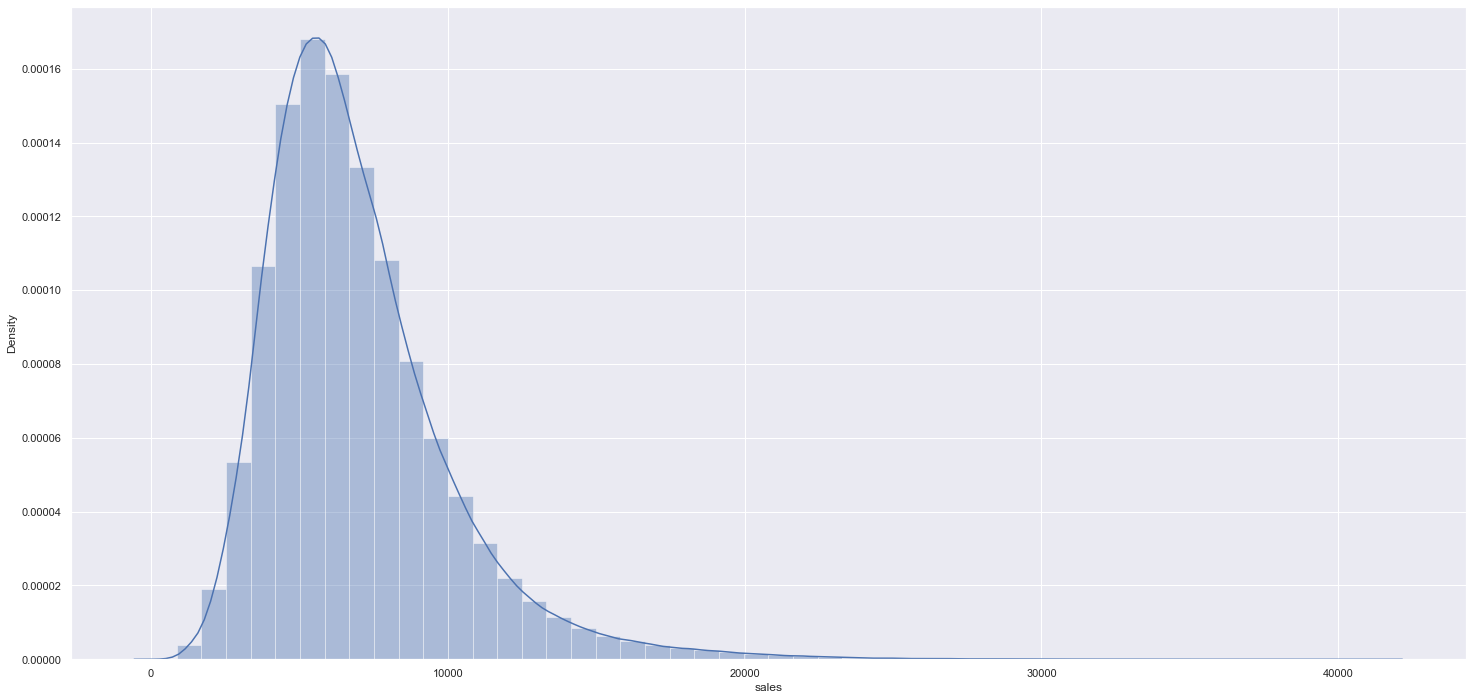

In [27]:
sns.distplot(df4['sales']);

### Numerical Variable

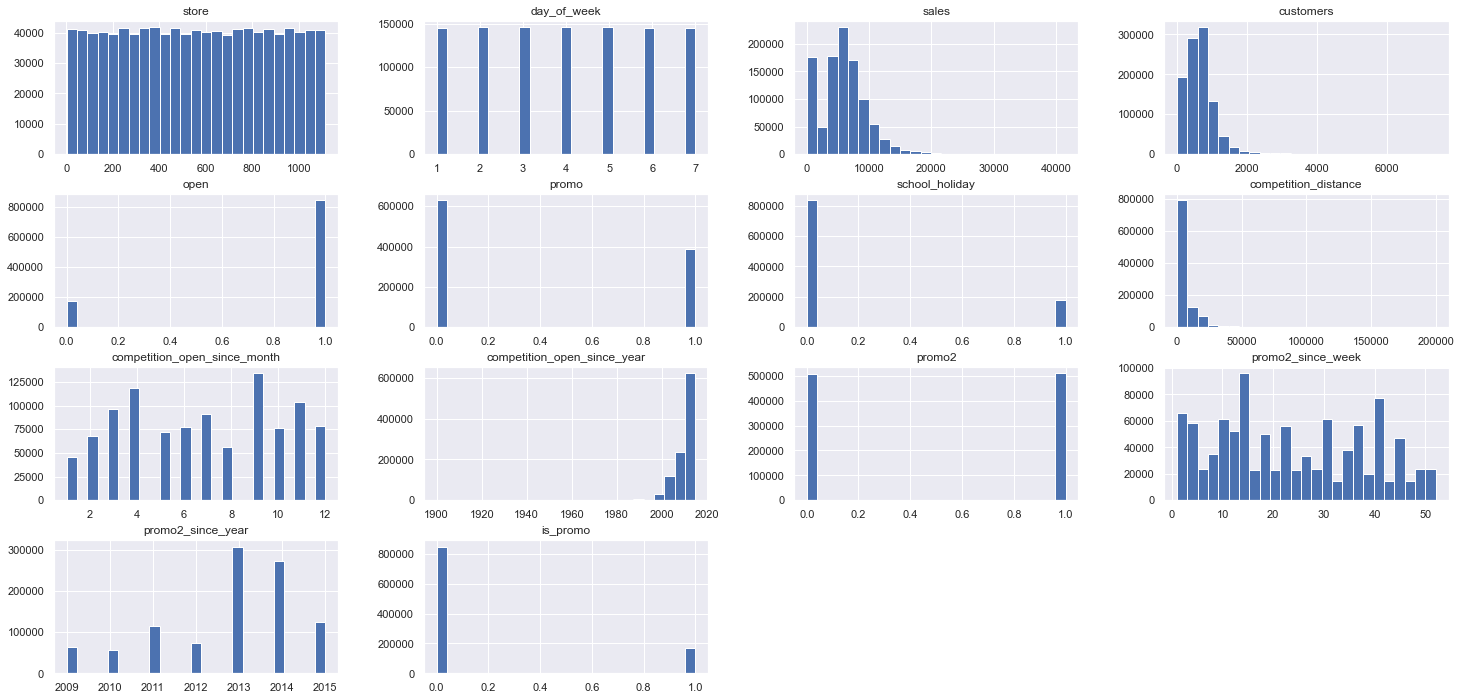

In [28]:
num_att.hist(bins=25);

### Categorical Variable

In [29]:
df4['assortment'].drop_duplicates()

0         basic
3      extended
258       extra
Name: assortment, dtype: object

<AxesSubplot:xlabel='sales', ylabel='Density'>

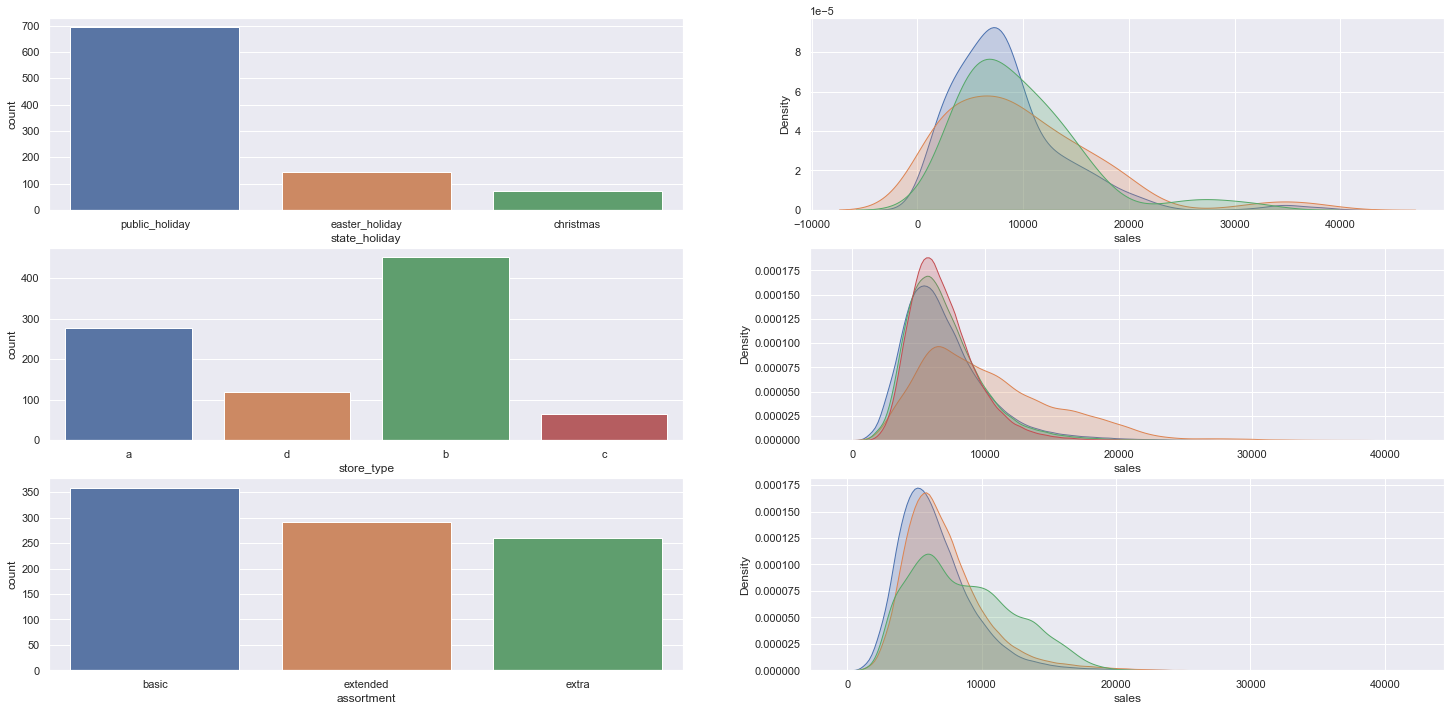

In [30]:
# state_holiday
aux = df4[df4['state_holiday'] != 'regular_day']
plt.subplot(3, 2, 1)
sns.countplot(aux['state_holiday'])

plt.subplot(3, 2, 2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', shade=True)

# store_type
plt.subplot(3, 2, 3)
sns.countplot(aux['store_type'])

plt.subplot(3, 2, 4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label='a', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label='b', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label='c', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label='d', shade=True)

# assortment
plt.subplot(3, 2, 5)
sns.countplot(aux['assortment'])

plt.subplot(3, 2, 6)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label='basic', shade=True)
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label='extended', shade=True)
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label='extra', shade=True)



## Bivariate Analysis

### 1. Stores with greater assortments should sell more.

- False. Stores with a smaller assortment sell more.

<AxesSubplot:xlabel='year_week'>

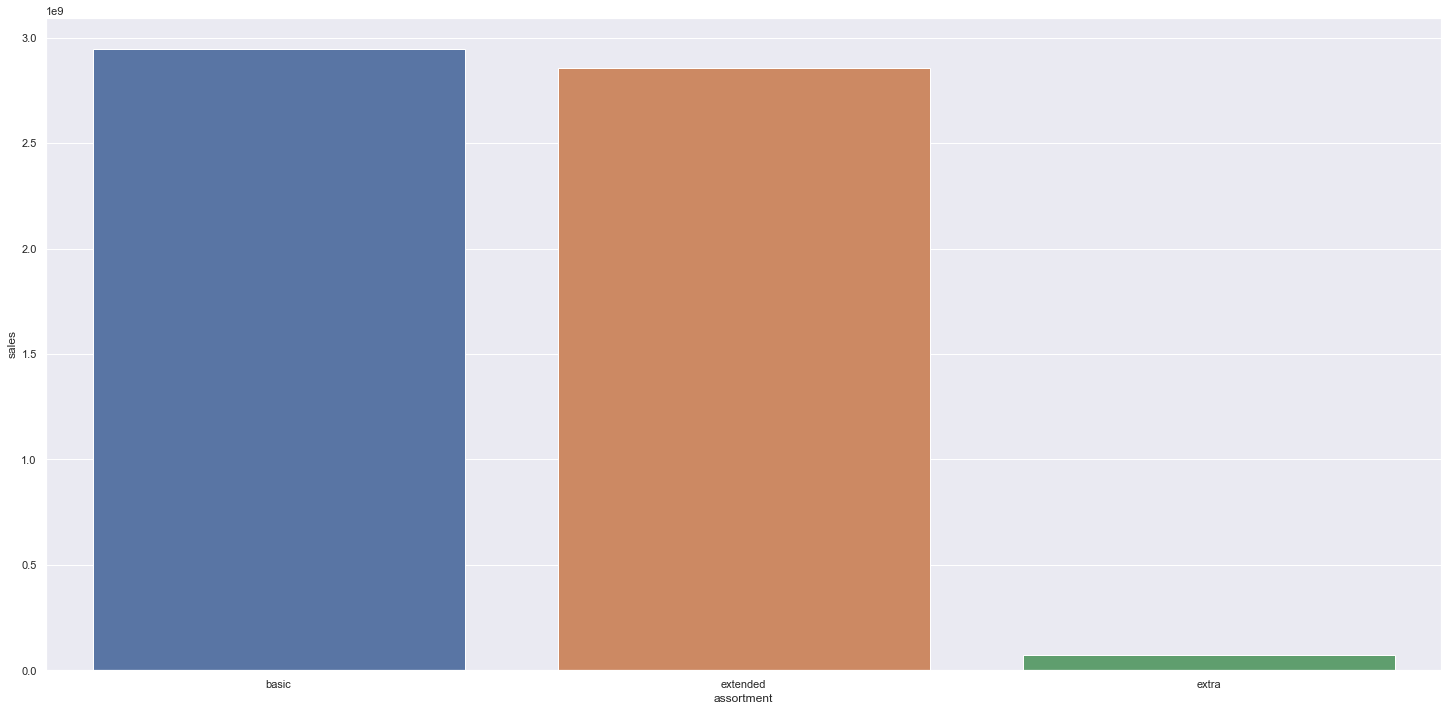

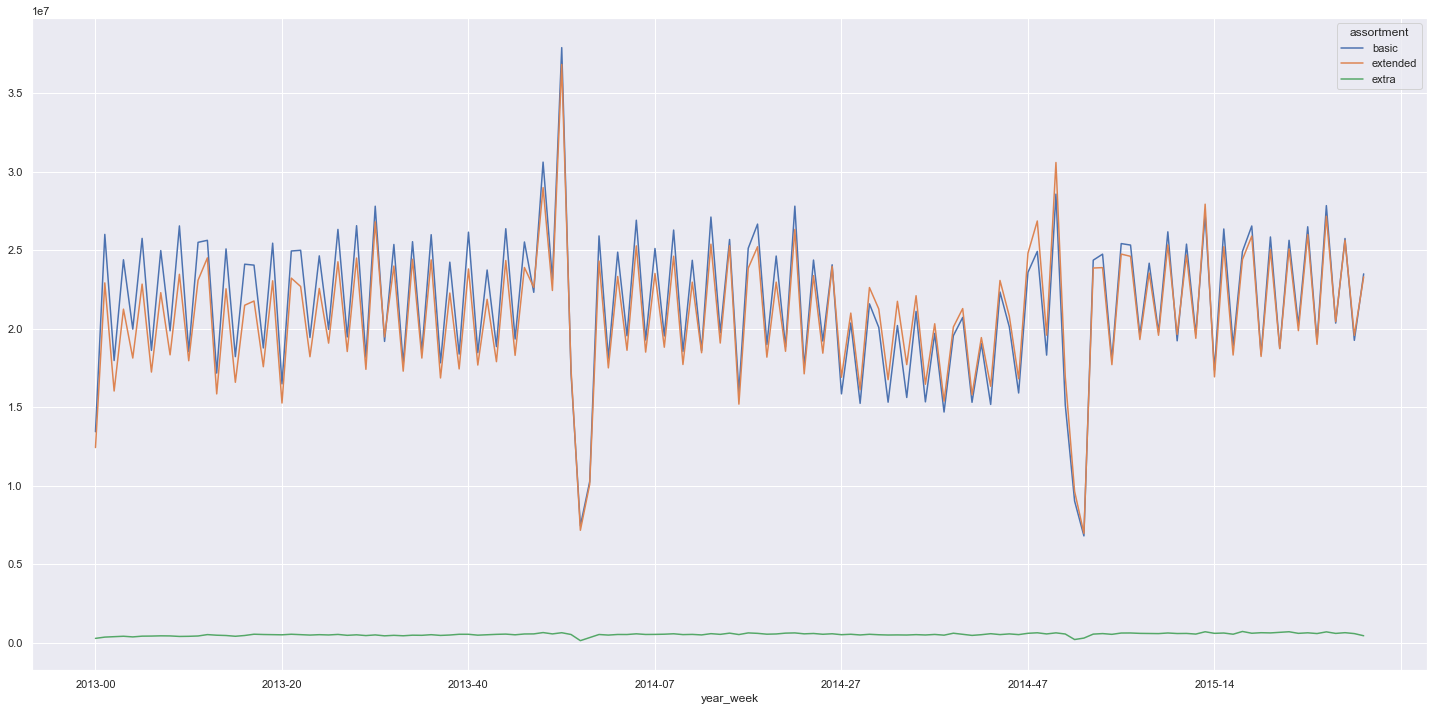

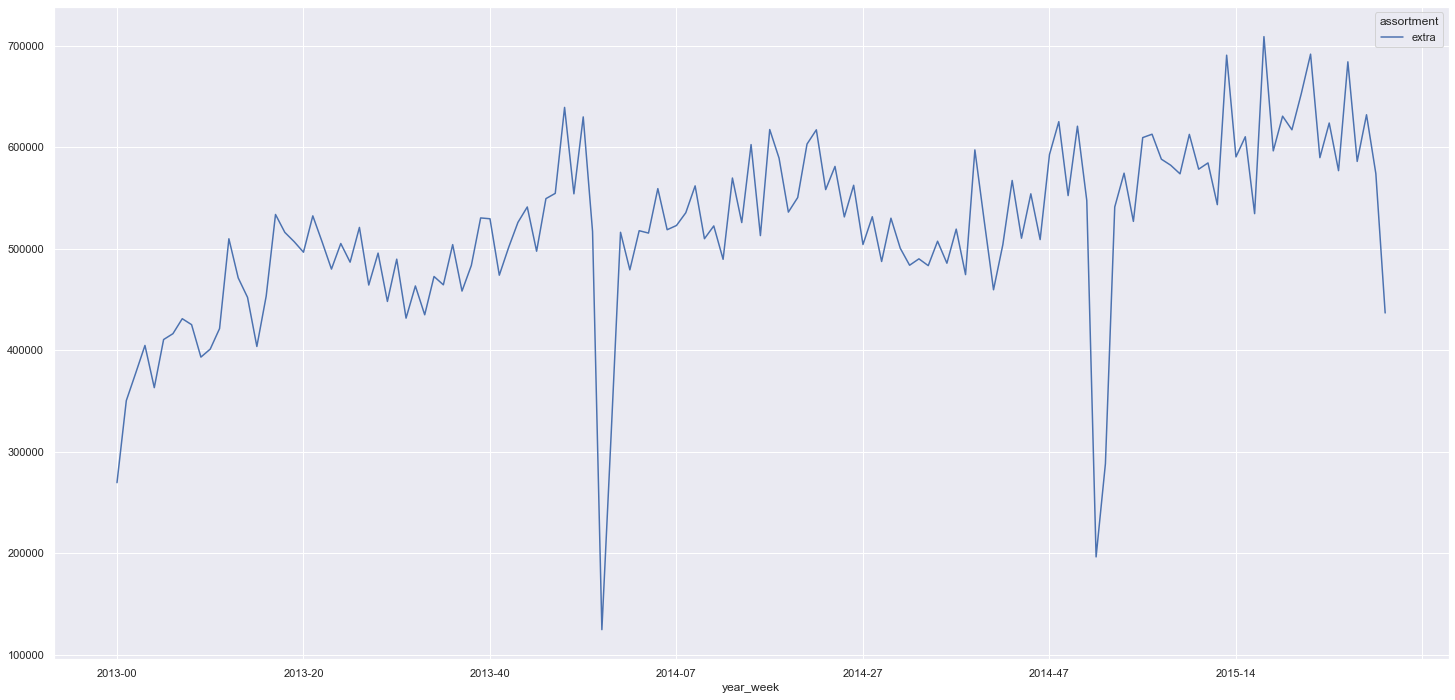

In [31]:
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot(x='assortment', y='sales', data=aux1)

aux2 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week', 'assortment']).sum().reset_index()
aux2.pivot(index='year_week', columns='assortment', values='sales').plot()

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot(index='year_week', columns='assortment', values='sales').plot()

### 2. Stores with closer competitors should sell less.

- False. Stores with closer competitors sell more.

<AxesSubplot:>

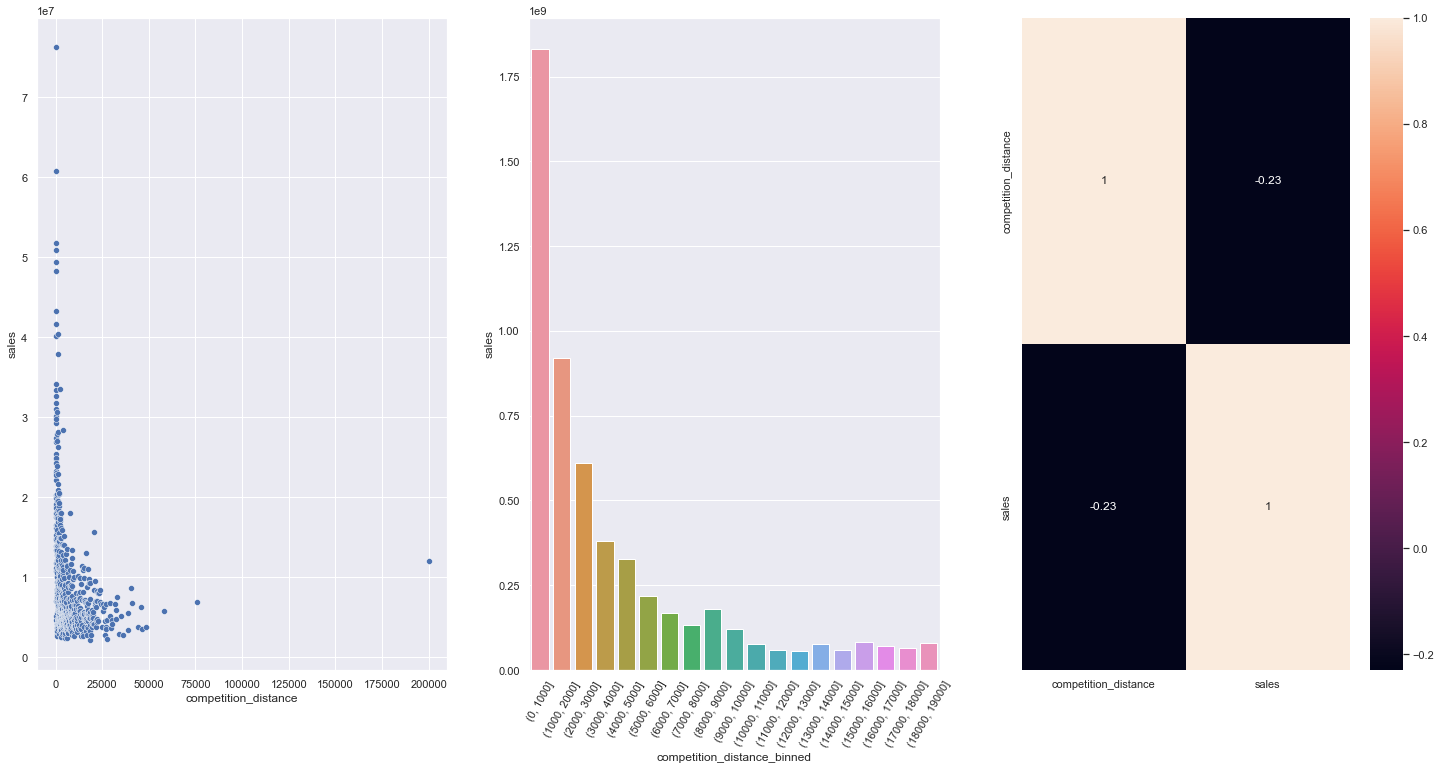

In [32]:
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

plt.subplot(1, 3, 1)
sns.scatterplot(x='competition_distance', y='sales', data=aux1)

bins = list(arange(0, 20000, 1000))

aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins)
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()

plt.subplot(1, 3, 2)
sns.barplot(x='competition_distance_binned', y='sales', data=aux2)
plt.xticks(rotation=60)

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)

### 3. Stores with longer competitors should sell more.

- False. Stores with longer competitors sell less

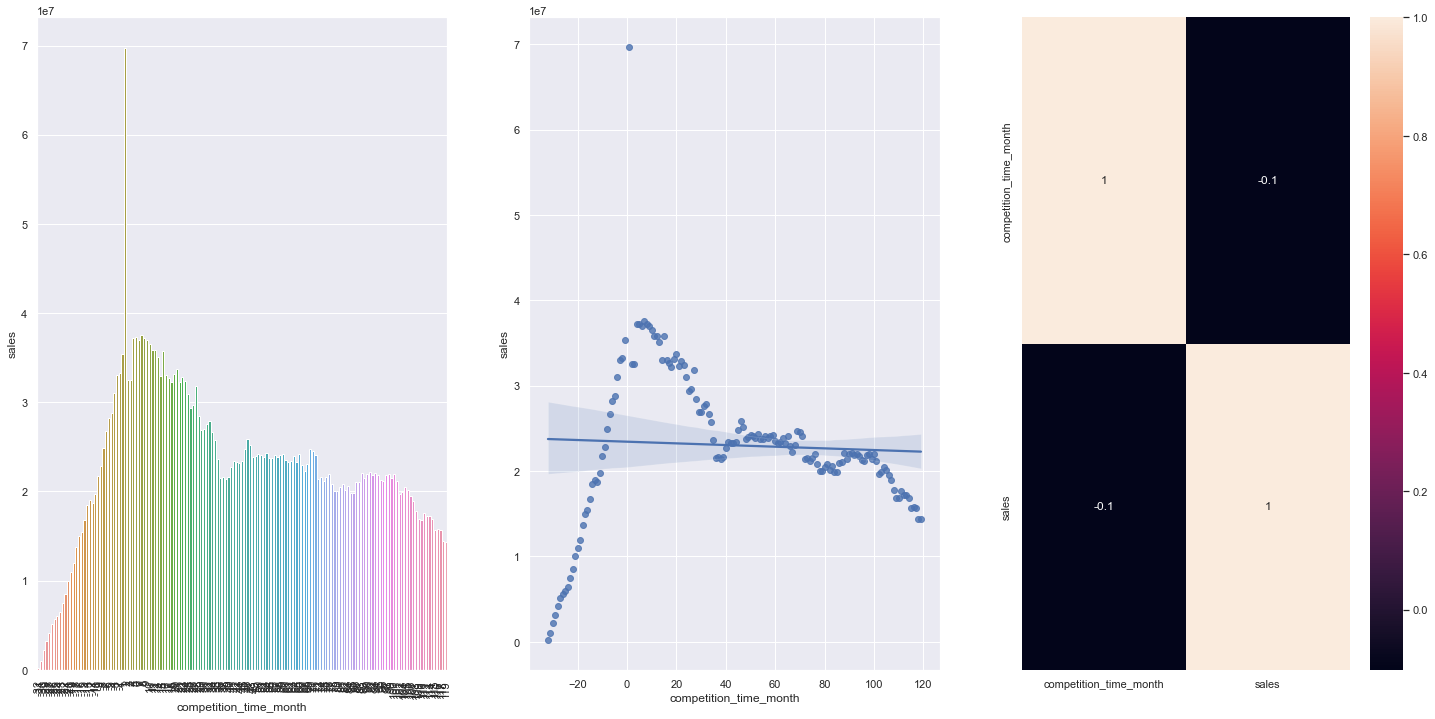

In [33]:
plt.subplot( 1, 3, 1 )
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month' ).sum().reset_index()
aux2 = aux1[( aux1['competition_time_month'] < 120 ) & (aux1['competition_time_month'] != 0 )]
sns.barplot( x='competition_time_month', y='sales', data=aux2 )
plt.xticks( rotation=90 )

plt.subplot( 1, 3, 2 )
sns.regplot( x='competition_time_month', y='sales', data=aux2 )

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson'), annot=True );

### 4. Stores with longer active promotions should sell more.

- False. Stores with promotions active for longer sell less, after a certain period of promotion.

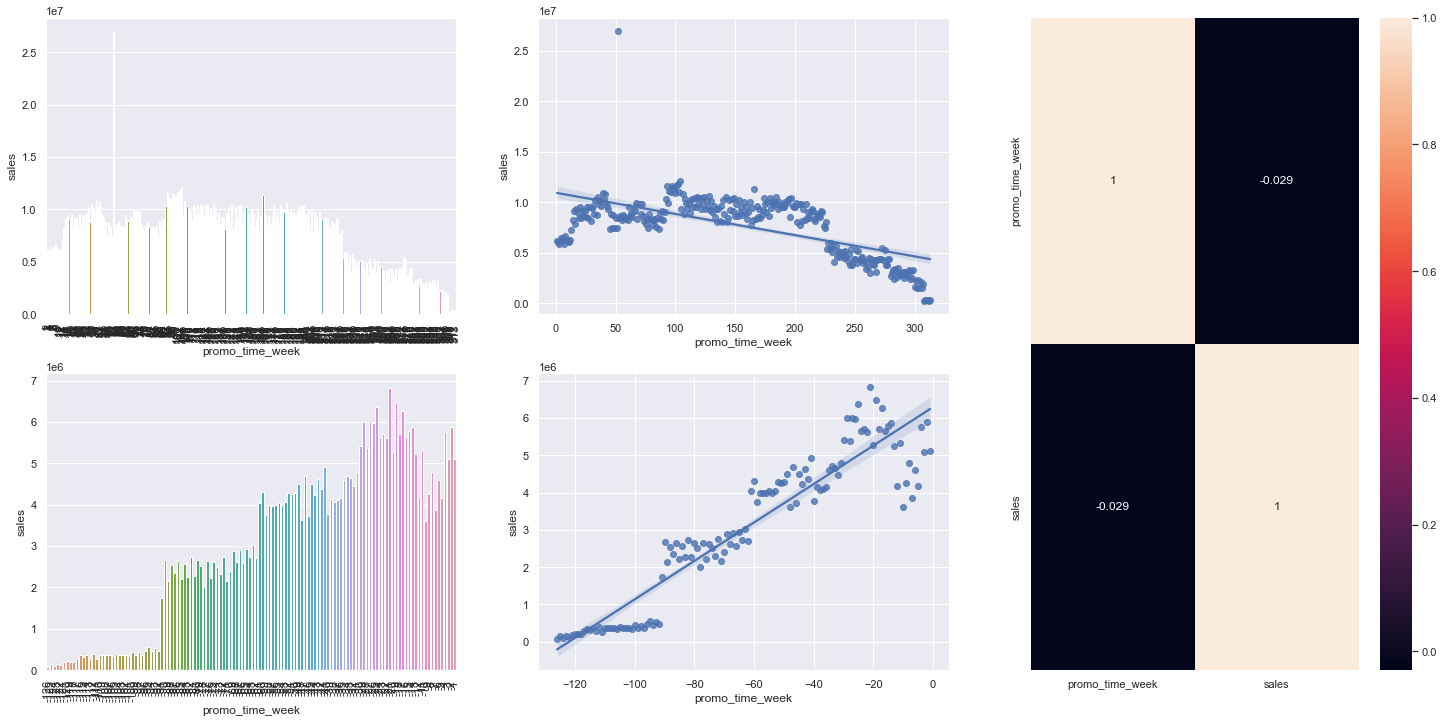

In [34]:
aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()
aux2 = aux1[aux1['promo_time_week'] > 0]
aux3 = aux1[aux1['promo_time_week'] < 0]

grid = GridSpec(2, 3)

plt.subplot(grid[0, 0])
sns.barplot(x='promo_time_week', y='sales', data=aux2)
plt.xticks(rotation=90)

plt.subplot(grid[0, 1])
sns.regplot( x='promo_time_week', y='sales', data=aux2 )

plt.subplot(grid[1, 0])
sns.barplot(x='promo_time_week', y='sales', data=aux3)
plt.xticks(rotation=90)

plt.subplot(grid[1, 1])
sns.regplot( x='promo_time_week', y='sales', data=aux3)

plt.subplot(grid[:, 2])
sns.heatmap( aux1.corr(method='pearson'), annot=True);

### 5. Stores with more consecutive promotions should sell more.

- False. Stores with more consecutive promotions sell less.

In [35]:
df4[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


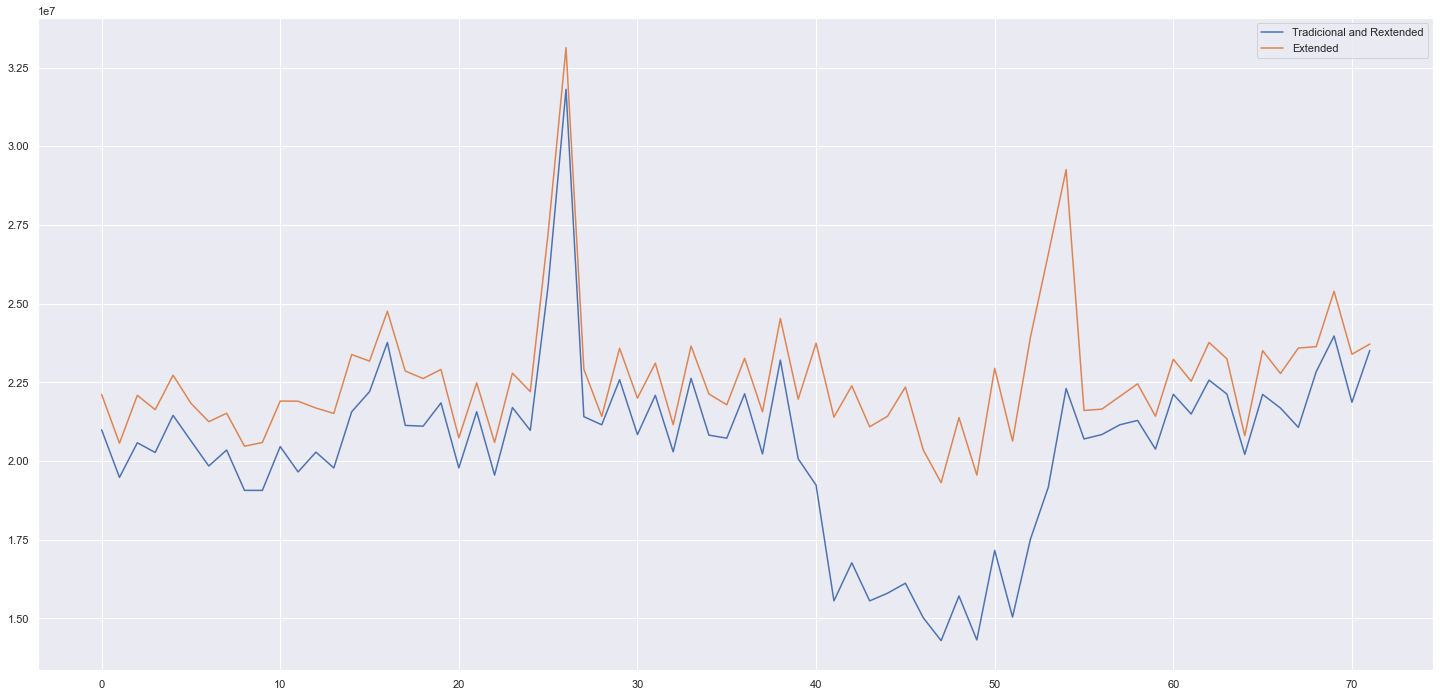

In [36]:
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week', 'sales']].groupby('year_week').sum().reset_index()

ax = aux1.plot()
aux2.plot(ax=ax)

ax.legend(labels=['Tradicional and Rextended', 'Extended']);

### 6. Stores open during the Christmas holiday should sell more.

- False. Stores open during the Christmas holiday sell less

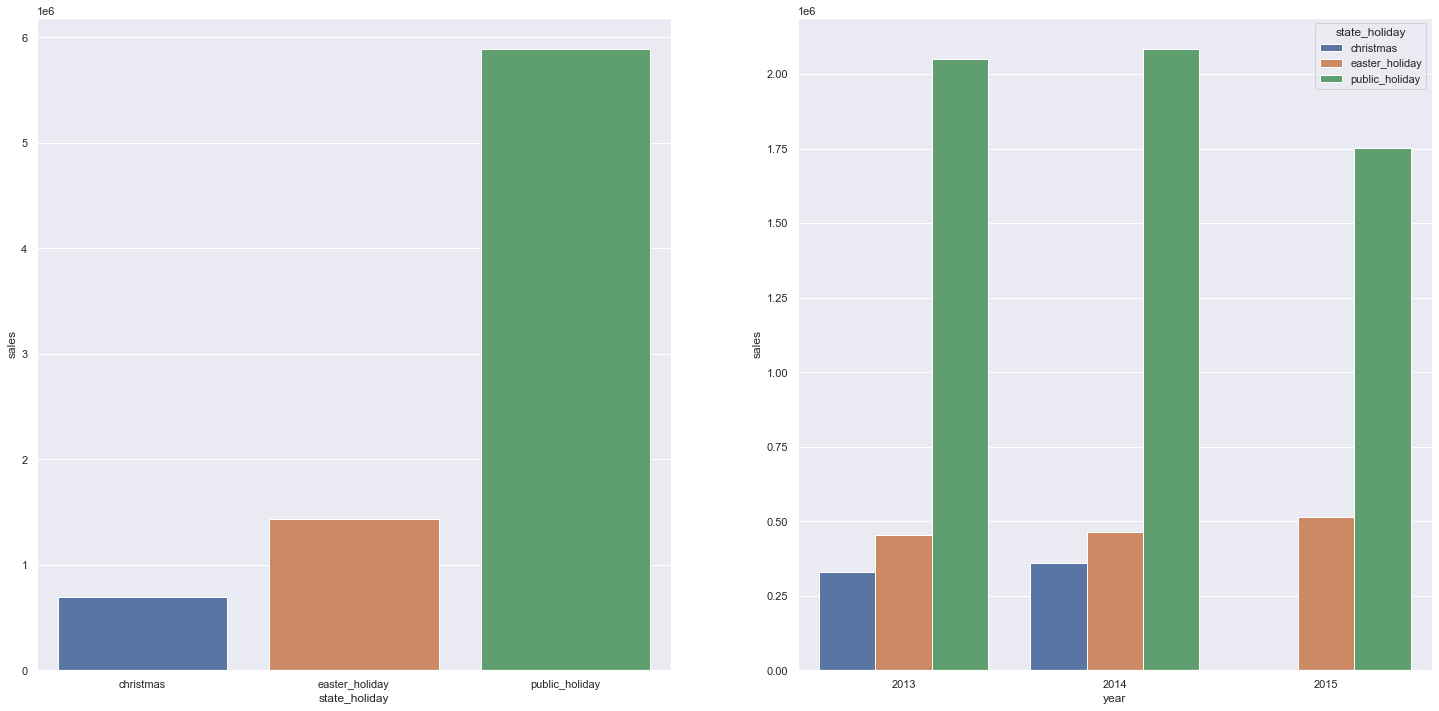

In [37]:
aux = df4[df4['state_holiday'] != 'regular_day']
aux1 = aux[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
aux2 = aux[['year', 'state_holiday', 'sales']].groupby(['year', 'state_holiday']).sum().reset_index()

plt.subplot(1, 2, 1)
sns.barplot(x='state_holiday', y='sales', data=aux1)

plt.subplot(1, 2, 2)
sns.barplot(x='year', y='sales', hue='state_holiday', data=aux2);

### 7. Stores should sell more over the years.

- False. Stores sell less over the years.

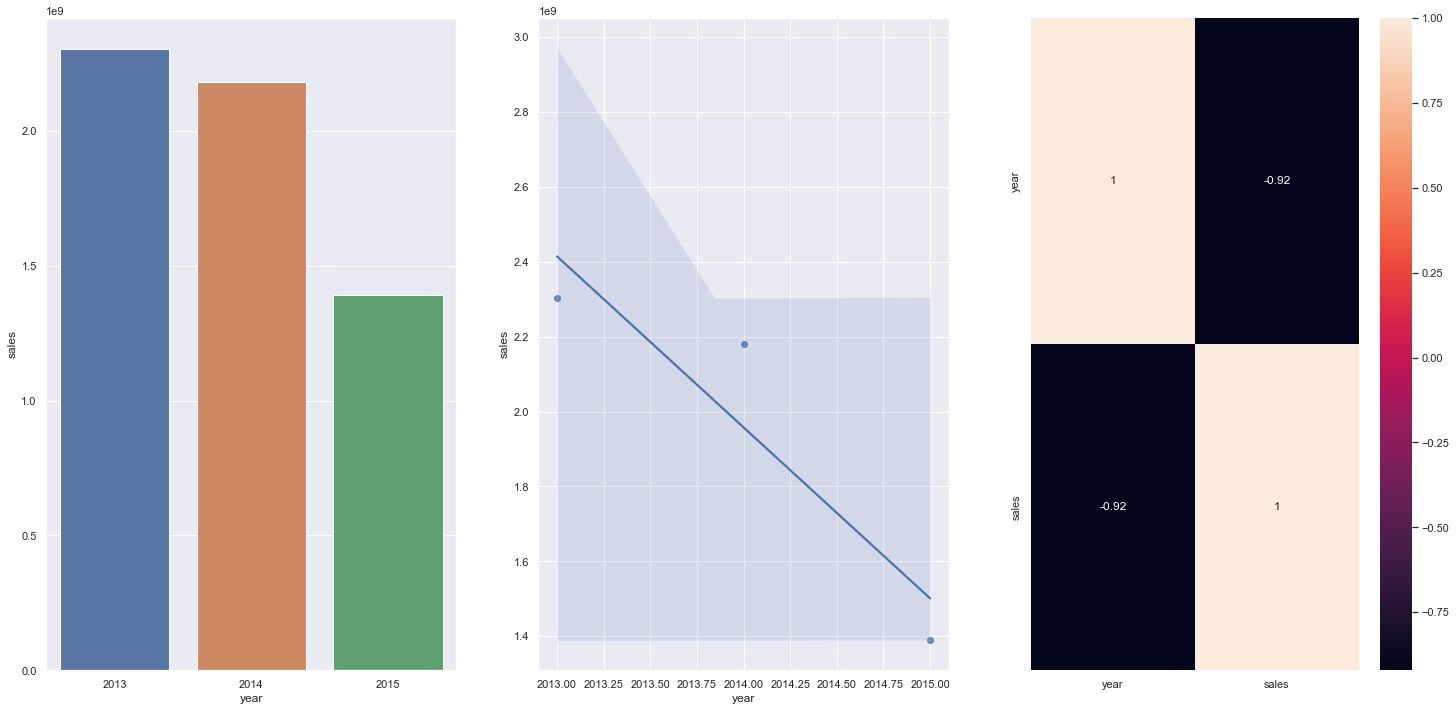

In [38]:
aux1 = df4[['year', 'sales']].groupby('year').sum().reset_index()

plt.subplot(1, 3, 1)
sns.barplot(x='year', y='sales', data=aux1)

plt.subplot(1, 3, 2)
sns.regplot(x='year', y='sales', data=aux1)

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### 8. Stores should sell more in the second half of the year.

- False. Stores sell more in the first half of the year.

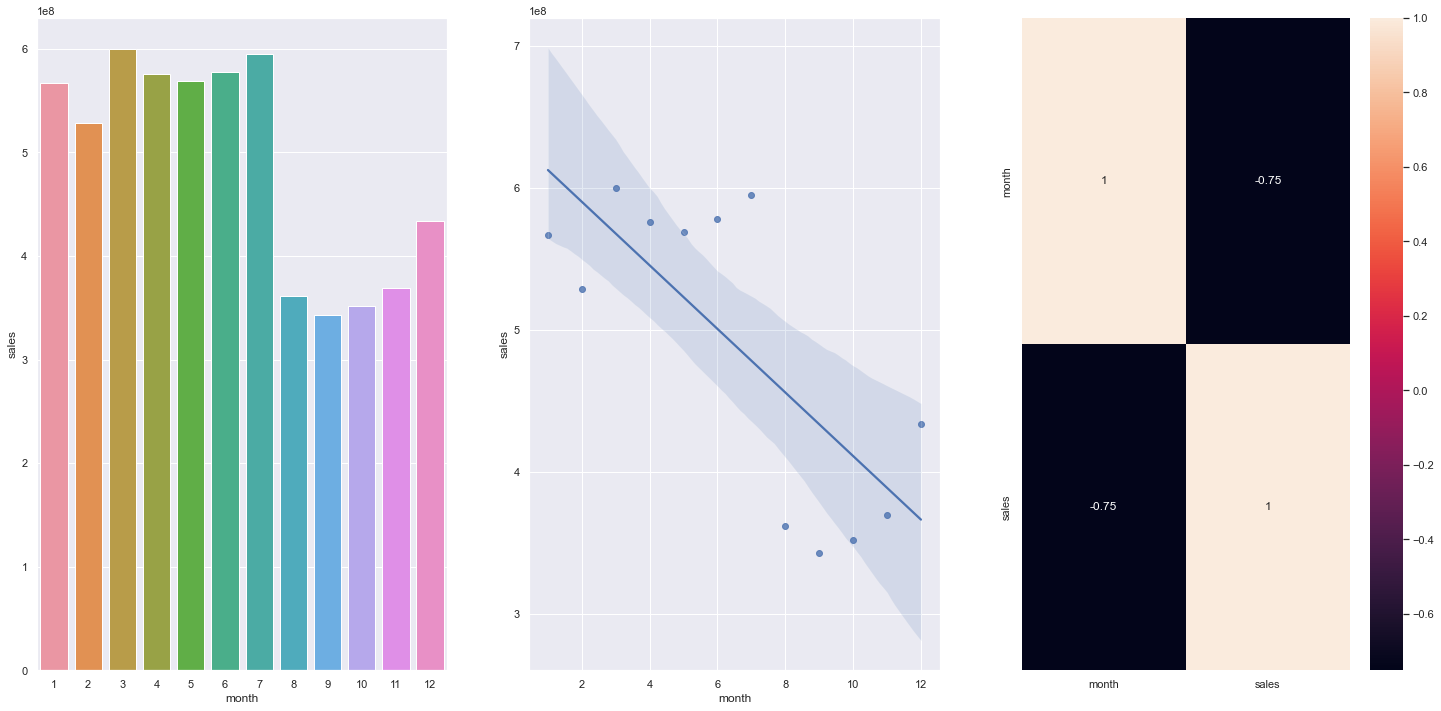

In [39]:
aux1 = df4[['month', 'sales']].groupby('month').sum().reset_index()

plt.subplot(1, 3, 1)
sns.barplot(x='month', y='sales', data=aux1)

plt.subplot(1, 3, 2)
sns.regplot(x='month', y='sales', data=aux1)

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### 9. Stores should sell more after the 10th of each month.


- True. Stores sell more after the 10th of each month.

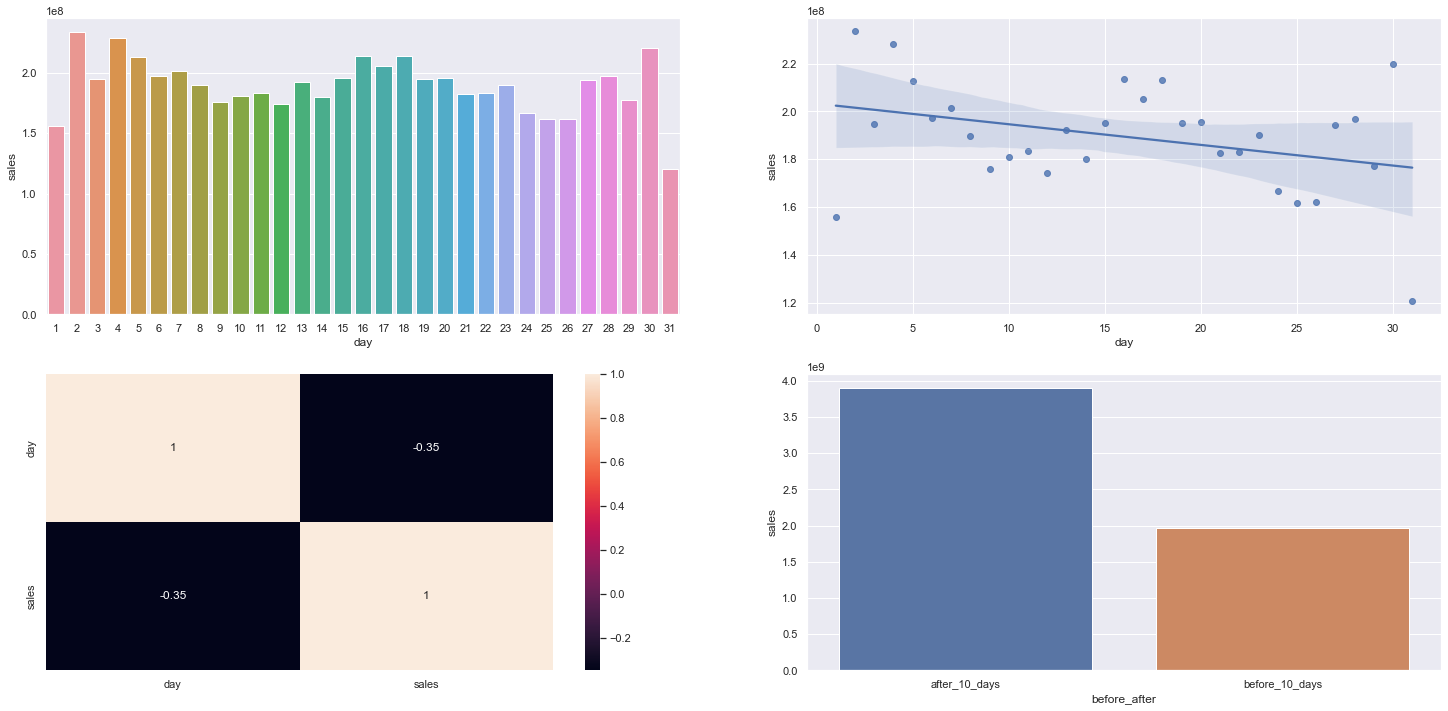

In [40]:
aux1 = df4[['day', 'sales']].groupby('day').sum().reset_index()
aux1['before_after'] = aux1['day'].apply(lambda x: 'before_10_days' 
                                         if x <= 10 
                                         else 'after_10_days')
aux2 = aux1[['before_after', 'sales']].groupby('before_after').sum().reset_index()

plt.subplot(2, 2, 1)
sns.barplot(x='day', y='sales', data=aux1)

plt.subplot(2, 2, 2)
sns.regplot(x='day', y='sales', data=aux1)

plt.subplot(2, 2, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)

plt.subplot(2, 2, 4)
sns.barplot(x='before_after', y='sales', data=aux2);

### 10. Stores should sell less on weekends.

- True. Stores sell less on weekends.

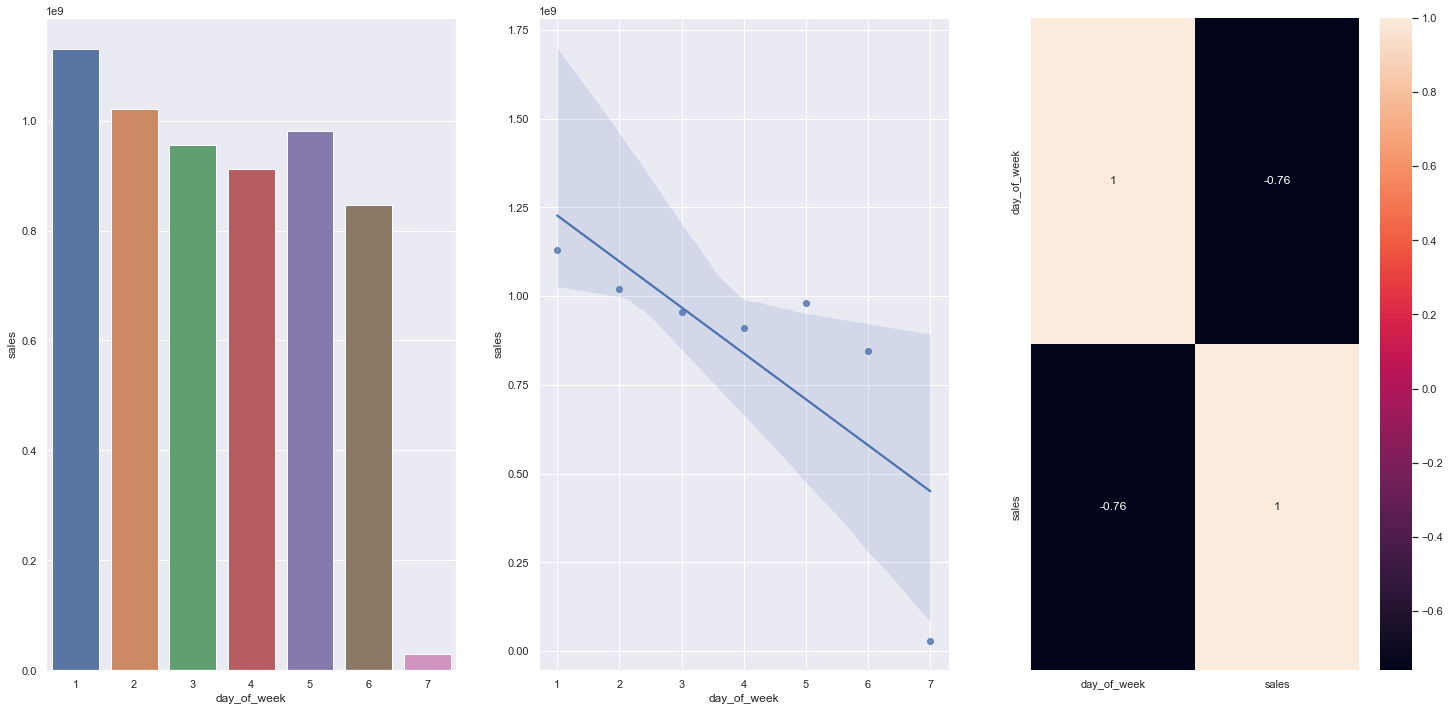

In [41]:
aux1 = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()

plt.subplot(1, 3, 1)
sns.barplot(x='day_of_week', y='sales', data=aux1)

plt.subplot(1, 3, 2)
sns.regplot(x='day_of_week', y='sales', data=aux1)

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### 11. Stores should sell less during school holidays.

- The stores sell less during the school holidays, except for the month of August (Note that in July sales almost equaled).

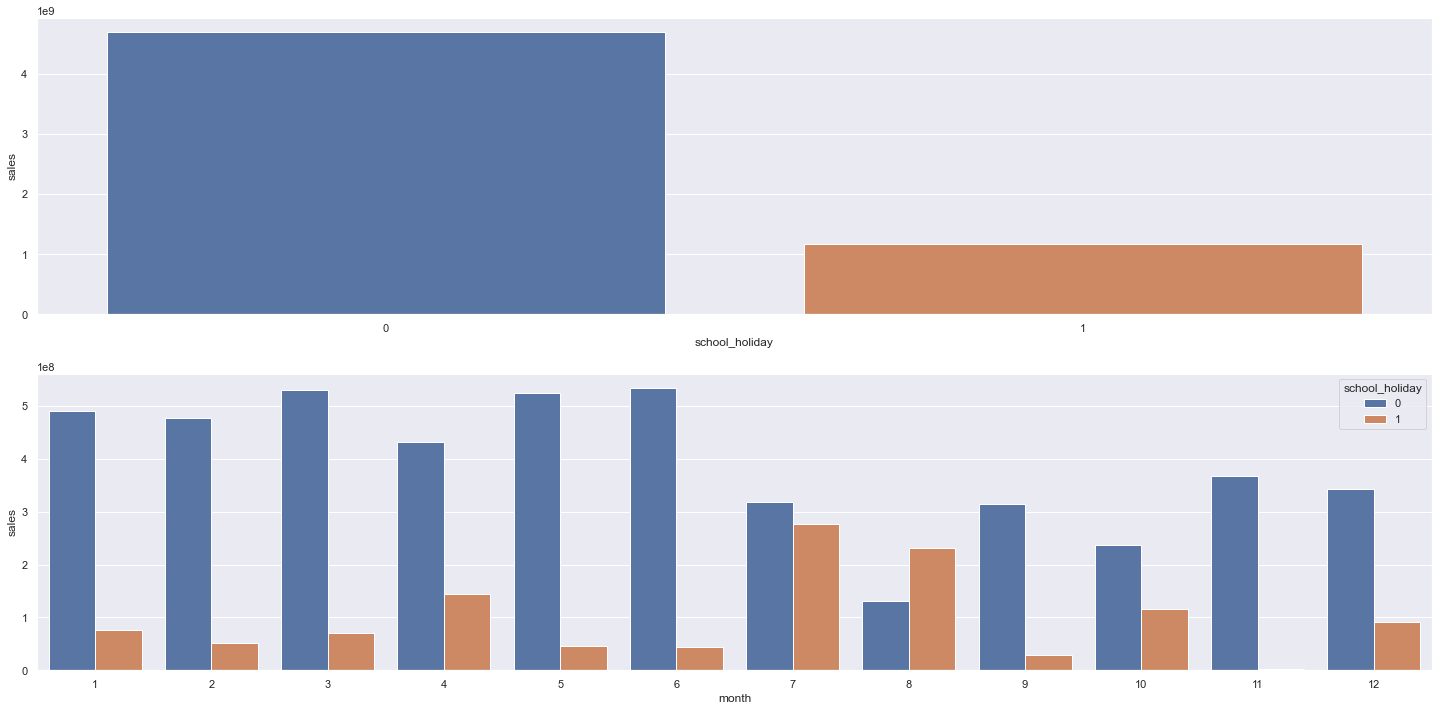

In [42]:
aux1 = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()
aux2 = df4[['month', 'school_holiday', 'sales']].groupby(['month', 'school_holiday']).sum().reset_index()

plt.subplot(2, 1, 1)
sns.barplot(x='school_holiday', y='sales', data=aux1)

plt.subplot(2, 1, 2)
sns.barplot(x='month', y='sales', hue='school_holiday', data=aux2);

## Multivariate Analysis

### Numerical Attributes

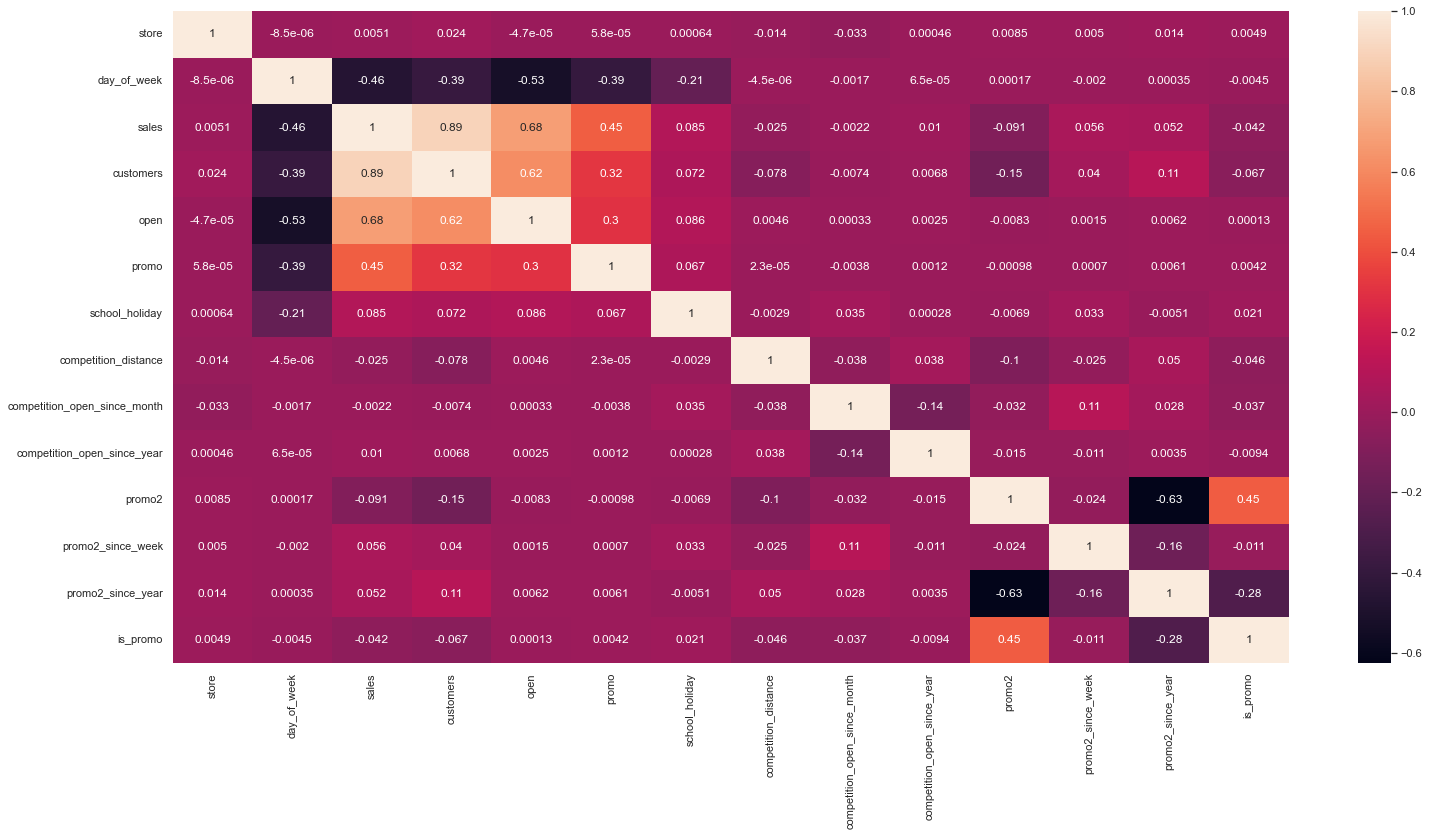

In [43]:
corr = num_att.corr(method='pearson')
sns.heatmap(corr, annot=True);

### Categorical Attributes

<AxesSubplot:>

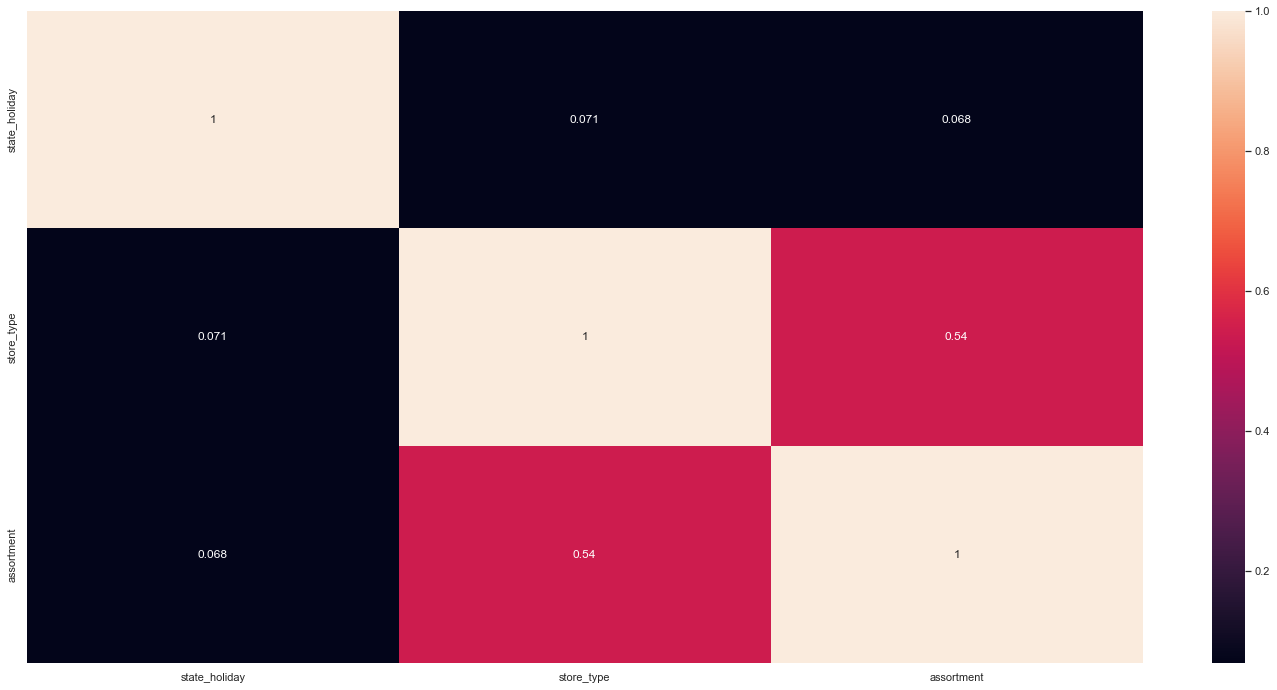

In [44]:
# only categorical data
aux = df4.select_dtypes(include='object')

# calculate cramer v
aux1 = cramer_v(aux['state_holiday'], aux['state_holiday'])
aux2 = cramer_v(aux['state_holiday'], aux['store_type'])
aux3 = cramer_v(aux['state_holiday'], aux['assortment'])

aux4 = cramer_v(aux['store_type'], aux['state_holiday'])
aux5 = cramer_v(aux['store_type'], aux['store_type'])
aux6 = cramer_v(aux['store_type'], aux['assortment'])

aux7 = cramer_v(aux['assortment'], aux['state_holiday'])
aux8 = cramer_v(aux['assortment'], aux['store_type'])
aux9 = cramer_v(aux['assortment'], aux['assortment'])

# final dataset
df = pd.DataFrame({'state_holiday': [aux1, aux2, aux3],
              'store_type': [aux4, aux5, aux6],
              'assortment': [aux7, aux8, aux9]})

df = df.set_index(df.columns)

sns.heatmap(df, annot=True)

# Data Preparation

In [45]:
df5 = df4.copy()

## Rescaling

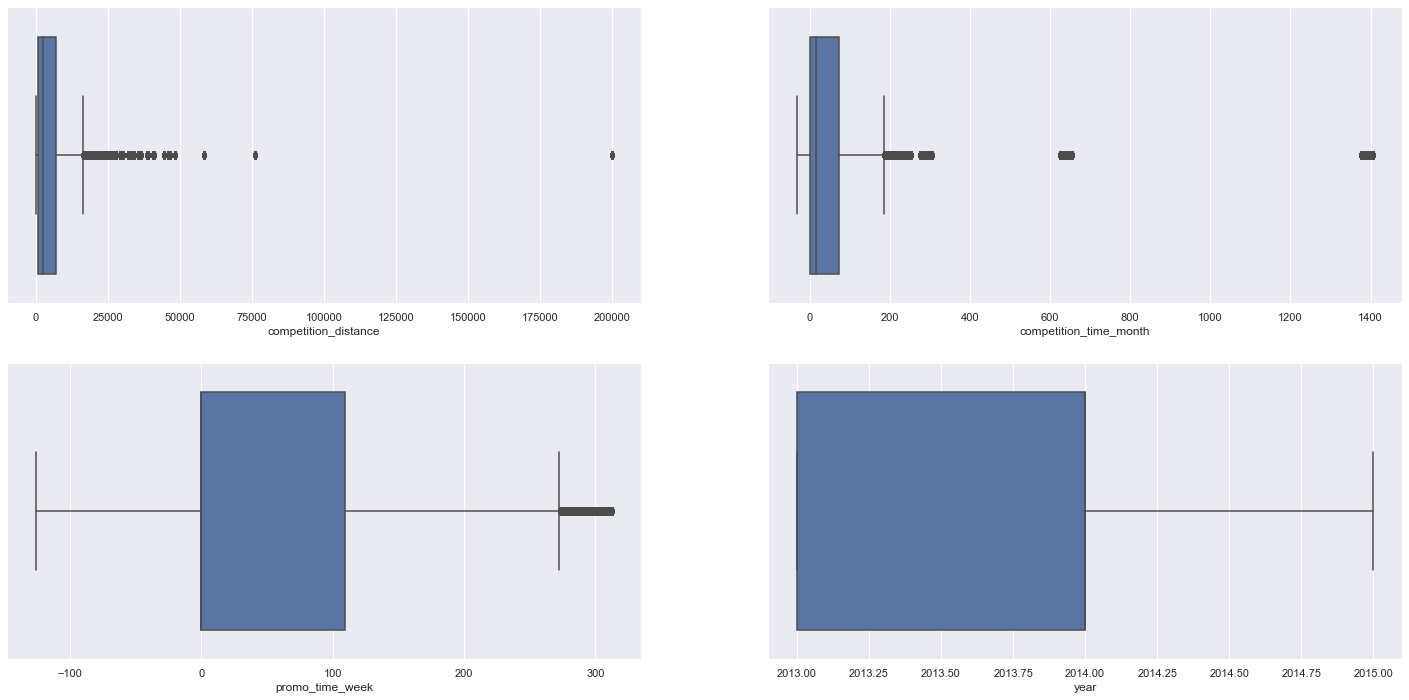

In [46]:
plt.subplot(2, 2, 1)
sns.boxplot(df5['competition_distance'])

plt.subplot(2, 2, 2)
sns.boxplot(df5['competition_time_month'])

plt.subplot(2, 2, 3)
sns.boxplot(df5['promo_time_week'])

plt.subplot(2, 2, 4)
sns.boxplot(df5['year']);

In [47]:
rs = RobustScaler()
mms = MinMaxScaler()

# competition distance
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)
pickle.dump(rs, open('parameters/competition_distance_scaler.pkl', 'wb'))

# competition time month 
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)
pickle.dump(rs, open('parameters/competition_time_month_scaler.pkl', 'wb'))

# promo time week
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)
pickle.dump(mms, open('parameters/promo_time_week_scaler.pkl', 'wb'))

# year 
df5['year'] = mms.fit_transform(df5[['year']].values)
pickle.dump(mms, open('parameters/year_scaler.pkl', 'wb'))

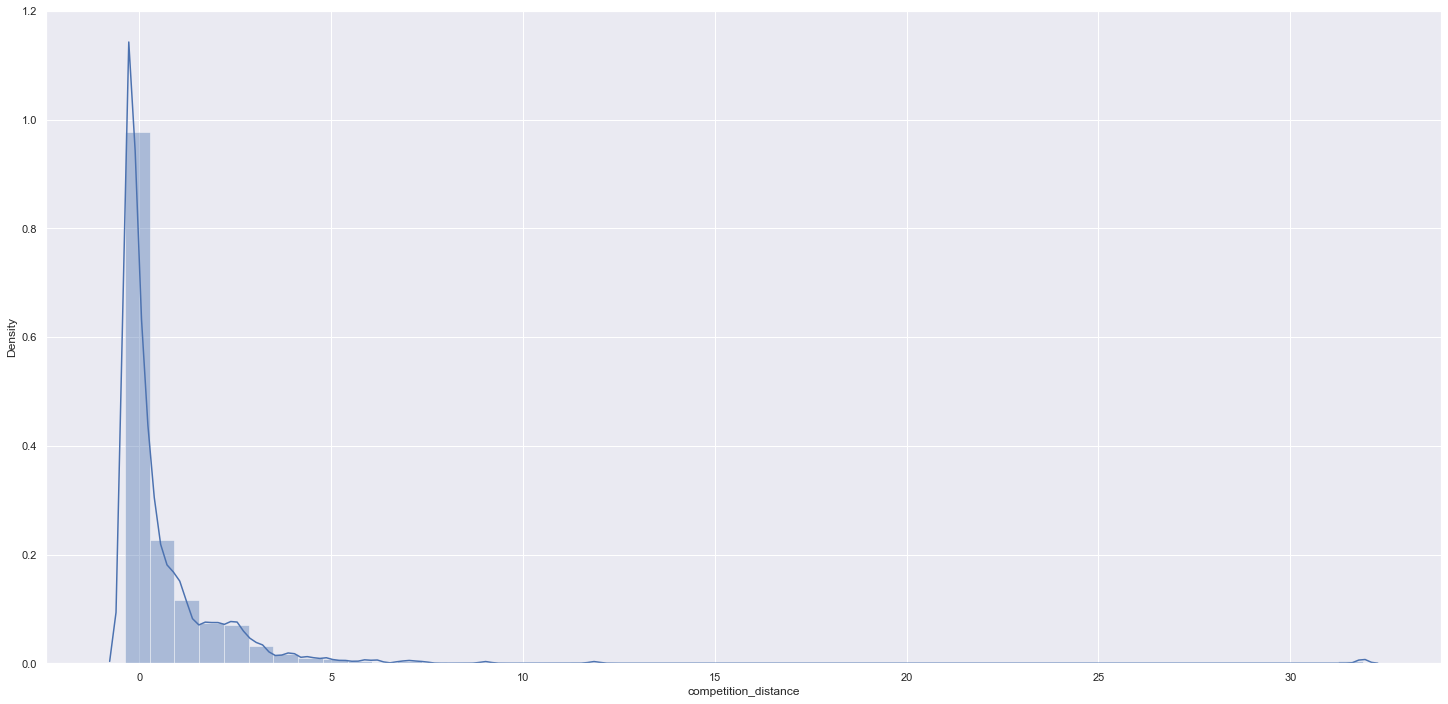

In [48]:
sns.distplot(df5['competition_distance']);

## Transformation

### Encoding

In [49]:
le = LabelEncoder()

# state holiday - one hot encoding
df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])

# store type - label encoding
df5['store_type'] = le.fit_transform(df5['store_type'])
pickle.dump(le, open('parameters/store_type_scaler.pkl', 'wb'))

# assortment - ordinal encoding
assortment_dict = {'basic': 1,'extended': 2, 'extra': 3}
df5['assortment'] = df5['assortment'].map(assortment_dict)

### Response Variable Transformation

In [50]:
df5['sales'] = np.log1p(df5['sales'])

### Nature Transformation

In [51]:


# month
df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x*(2.*np.pi/12)))
df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x*(2.*np.pi/12)))

# day
df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x*(2.*np.pi/30)))
df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x*(2.*np.pi/30)))

# week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x*(2.*np.pi/52)))
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x*(2.*np.pi/52)))

# day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x*(2.*np.pi/7)))
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x*(2.*np.pi/7)))

# Feature Selection

In [52]:
df6 = df5.copy()

## Split dataframe into training and test dataset

In [53]:
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week']
df6 = df6.drop(cols_drop, axis=1)

In [54]:
# training dataset
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

# test dataset
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

print('Training Min Date: {}'.format( X_train['date'].min()))
print('Training Max Date: {}'.format( X_train['date'].max()))
print('\nTest Min Date: {}'.format( X_test['date'].min()))
print('Test Max Date: {}'.format( X_test['date'].max()))

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00


## Boruta as Feature Selector

In [55]:
# training and test dataset for boruta
#x_train_n = X_train.drop(['sales', 'date'], axis=1).values
#y_train_n = y_train.values.ravel()

# define RandomForestRegressor
#rf = RandomForestRegressor(n_jobs=-1)

# define boruta
#boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42).fit(x_train_n, y_train_n)

### Best Features from Boruta

In [56]:
#cols_selected = boruta.support_.tolist()

#best features
#x_train_fs = x_train.drop(['date', 'sales'], axis=1)
#cols_selected_boruta = x_train_fs.iloc[:, cols_selected].columns.to_list()

# not selected boruta
#cols_not_selected_boruta = list(np.setdiff1d(x_train_fs.columns, cols_selected_boruta))

## Manual Feature Selection

In [57]:
cols_selected_boruta = ['store', 
                        'promo',
                        'store_type',
                        'assortment',
                        'competition_distance',
                        'competition_open_since_month',
                        'competition_open_since_year',
                        'promo2',
                        'promo2_since_week',
                        'promo2_since_year',
                        'competition_time_month',
                        'promo_time_week',
                        'month_sin',
                        'month_cos',
                        'day_sin',
                        'day_cos',
                        'week_of_year_sin',
                        'week_of_year_cos',
                        'day_of_week_sin',
                        'day_of_week_cos']

# columns to add
feat_to_add = ['date', 'sales']

cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend( feat_to_add )

# Machine Learning Modeling

In [58]:
df7 = df6.copy()

In [59]:
x_train = X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]

# Time Series Data Preparation
x_training = X_train[ cols_selected_boruta_full ]

## Average Model

In [60]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

# prediction
aux2 = aux1[['store', 'sales']].groupby( 'store' ).mean().reset_index().rename(columns={'sales': 'predictions'})
aux1 = pd.merge(aux1, aux2, how='left', on='store')
yhat_baseline = aux1['predictions']

# performance
baseline_result = ml_error('Average Model', np.expm1( y_test ), np.expm1(yhat_baseline))
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.2064,1835.135542


## Linear Regression Model

In [61]:
# model
lr = LinearRegression().fit(x_train, y_train)

# prediction
yhat_lr = lr.predict(x_test)

# performance
lr_result = ml_error('Linear Regression', np.expm1(y_test), np.expm1(yhat_lr))
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1861.127229,0.291652,2662.291292


### Linear Regression Model - Cross Validation

In [62]:
lr_result_cv = cross_validation( x_training, 5, 'Linear Regression', lr, verbose=False )
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2077.72 +/- 295.95,0.3 +/- 0.02,2945.54 +/- 469.14


## Linear Regression Regularized Model - Lasso

In [63]:
# model
lrr = Lasso( alpha=0.01 ).fit( x_train, y_train )

# prediction
yhat_lrr = lrr.predict( x_test )

# performance
lrr_result = ml_error( 'Linear Regression - Lasso', np.expm1( y_test ), np.expm1( yhat_lrr ) )
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1891.398668,0.289252,2743.459416


### Lasso - Cross Validation

In [64]:
lrr_result_cv = cross_validation( x_training, 5, 'Lasso', lrr, verbose=False )
lrr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso,2117.99 +/- 342.74,0.29 +/- 0.01,3058.18 +/- 506.07


##  Random Forest Regressor

In [65]:
# model
#rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42).fit(x_train, y_train)

# prediction
#yhat_rf = rf.predict( x_test )

# performance
#rf_result = ml_error('Random Forest Regressor', np.expm1(y_test), np.expm1(yhat_rf))
#rf_result

###  Random Forest Regressor - Cross Validation

In [66]:
#rf_result_cv = cross_validation( x_training, 5, 'Random Forest Regressor', rf, verbose=True)
#rf_result_cv

## XGBoost Regressor

In [67]:
# model
#model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
#                              n_estimators=100,
#                              eta=0.01,
#                              max_depth=10,
#                              subsample=0.7,
#                              colsample_bytee=0.9).fit(x_train, y_train)

# prediction
#yhat_xgb = model_xgb.predict(x_test)

# performance
#xgb_result = ml_error( 'XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb))
#xgb_result

### XGBoost Regressor - Cross Validation

In [68]:
#xgb_result_cv = cross_validation( x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True )
#xgb_result_cv

## Comparing results of the models

### Single Performance

In [69]:
#modeling_result = pd.concat([baseline_result, lr_result, lrr_result, rf_result, xgb_result ])
#modeling_result.sort_values('RMSE')

### Real Performance - Cross Validation

In [70]:
#modelling_result_cv = pd.concat( [lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv] )
#modelling_result_cv

# Hyperparameter Fine Tuning

## Random Search

In [71]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start=200, stop=2000, num=6)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(1, 10, num=5)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [1, 2, 5]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [72]:
# Use the random search for best hyperparameters
#rf = RandomForestRegressor()
#rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid, n_iter=10, cv=5, verbose=2, random_state=42, n_jobs=-1)

# Fit the random search model
#rf_random.fit(x_train, y_train)

In [73]:
#rf_random.best_params_

## Final Model

In [74]:
# final model
rf_tuned = RandomForestRegressor(n_jobs=-1, 
                                 random_state=42,
                                 bootstrap=True,
                                 max_depth=None,
                                 max_features='auto',
                                 min_samples_leaf=1,
                                 min_samples_split=2,
                                 n_estimators=200).fit(x_train, y_train)

# prediction
yhat_rf_tuned = rf_tuned.predict(x_test)

# performance
rf_result_tuned = ml_error('Random Forest Regressor', np.expm1(y_test), np.expm1(yhat_rf_tuned))
rf_result_tuned

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,677.79253,0.099703,1008.031675


In [75]:
MPE = mean_percentage_error(np.expm1(y_test), np.expm1(yhat_rf_tuned))
MPE

-0.018979261594874324

# Metrics Comprehension

In [76]:
df8 = X_test[cols_selected_boruta_full]

# rescale
df8['sales'] = np.expm1(df8['sales'])
df8['predictions'] = np.expm1(yhat_rf_tuned)

## Business Performance

In [77]:
# sum of predictions
df81 = df8[['store', 'predictions']].groupby( 'store' ).sum().reset_index()

# MAE and MAPE
aux1 = df8[['store', 'sales', 'predictions']].groupby( 'store' ).apply(lambda x: mean_absolute_error(x['sales'], x['predictions'])).reset_index().rename(columns={0: 'MAE'})
aux2 = df8[['store', 'sales', 'predictions']].groupby( 'store' ).apply(lambda x: mean_absolute_percentage_error(x['sales'], x['predictions'])).reset_index().rename(columns={0: 'MAPE'})

# serge
aux3 = pd.merge(aux1, aux2, how='inner', on='store')
df82 = pd.merge(df81, aux3, how='inner', on='store')

# scenarios
df82['worst_scenario'] = df82['predictions'] - df82['MAE']
df82['best_scenario'] = df82['predictions'] + df82['MAE']



In [78]:
df82.sort_values('MAPE', ascending=False).head()

,store,predictions,MAE,MAPE,worst_scenario,best_scenario
291,292,109163.697751,3574.660208,0.613845,105589.037543,112738.357960
908,909,247848.592597,7039.573314,0.488173,240809.019284,254888.165911
549,550,260666.243397,1846.303876,0.370556,258819.939522,262512.547273
875,876,213269.423776,3867.339692,0.300835,209402.084084,217136.763468
182,183,205920.797891,1607.958885,0.266018,204312.839006,207528.756777


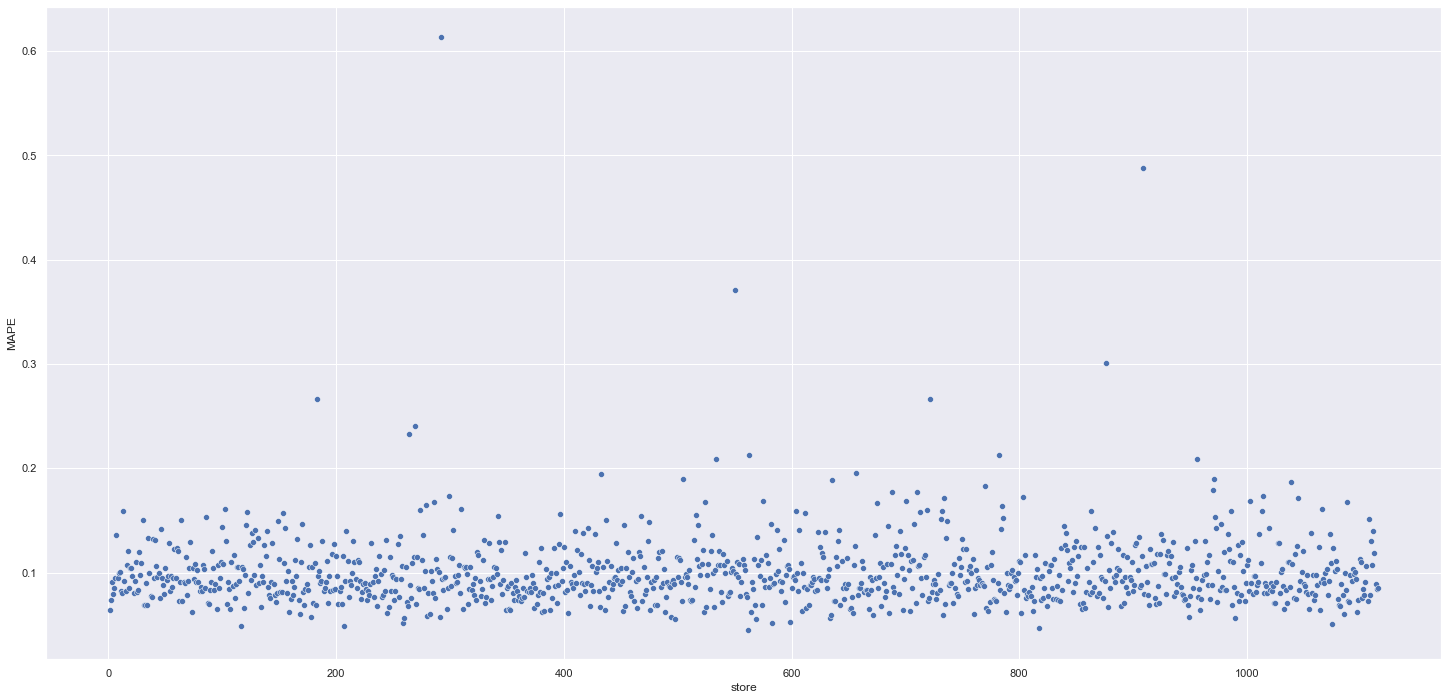

In [79]:
sns.scatterplot(x='store', y='MAPE', data=df82);

## Sales Performance

In [80]:
df83 = df82[['predictions', 'worst_scenario', 'best_scenario']].apply(lambda x: np.sum(x), axis=0).reset_index().rename(columns={'index': 'scenario', 0: 'values'})
df83['values'] = df83['values'].map('R${:,.2f}'.format)
df83

,scenario,values
0,predictions,"R$289,340,130.14"
1,worst_scenario,"R$288,580,731.07"
2,best_scenario,"R$290,099,529.20"


## Machine Learning Performance

In [81]:
df8['error'] = df8['sales'] - df8['predictions']
df8['error_rate'] = df8['predictions'] / df8['sales']

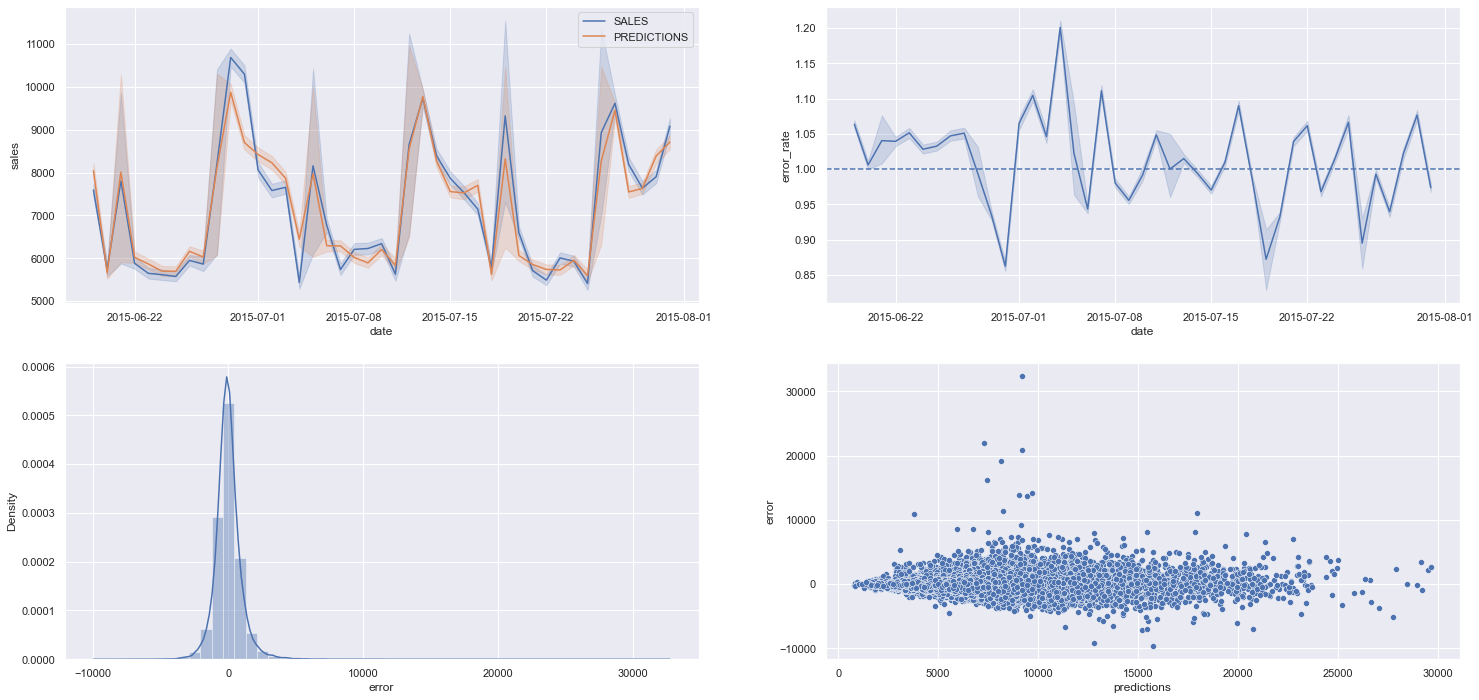

In [82]:
plt.subplot( 2, 2, 1 )
sns.lineplot( x='date', y='sales', data=df8, label='SALES' )
sns.lineplot( x='date', y='predictions', data=df8, label='PREDICTIONS' )

plt.subplot( 2, 2, 2 )
sns.lineplot( x='date', y='error_rate', data=df8 )
plt.axhline( 1, linestyle='--')

plt.subplot( 2, 2, 3 )
sns.distplot( df8['error'] )

plt.subplot( 2, 2, 4 )
sns.scatterplot( df8['predictions'], df8['error'] );

# Model Deploy

In [83]:
# save trained model
#pickle.dump(rf_tuned, open('model/model_rossmann.pkl', 'wb'))

## Rossmann Class

In [84]:
#import pickle
#import inflection
#import pandas as pd
#import numpy as np
#import math
#import datetime

#class Rossmann(object):
#    def __init__(self):
        
#        self.home_path = ''
#        self.competition_distance_scaler   = pickle.load( open( self.home_path + 'parameters/competition_distance_scaler.pkl', 'rb'))
#        self.year_scaler                   = pickle.load( open( self.home_path + 'parameters/year_scaler.pkl', 'rb'))
#        self.competition_time_month_scaler = pickle.load( open( self.home_path + 'parameters/competition_time_month_scaler.pkl', 'rb'))
#        self.promo_time_week_scaler        = pickle.load( open( self.home_path + 'parameters/promo_time_week_scaler.pkl', 'rb'))
#        self.store_type_scaler             = pickle.load( open( self.home_path + 'parameters/store_type_scaler.pkl', 'rb'))
    
#    def data_cleaning(self,df1)

        # rename columns
#        cols_old = ['Store', 'DayOfWeek', 'Date', 'Open',
#                    'Promo', 'StateHoliday', 'SchoolHoliday', 'StoreType', 
#                    'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth',
#                    'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
#                   'Promo2SinceYear', 'PromoInterval']

#        snakecase = lambda x: inflection.underscore(x)

#        cols_new = list(map(snakecase, cols_old))

#        df1.columns = cols_new
        
        # data types
#        df1['date'] = pd.to_datetime(df1['date'])
#        df1.dtypes
        
        # fillout NaN
        #competition_distance             
#        df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)
        
        #competition_open_since_month 
#        df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month 
#                                                        if math.isnan(x['competition_open_since_month']) 
#                                                        else x['competition_open_since_month'], axis=1)
        
#        #competition_open_since_year 
#        df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year 
#                                                        if math.isnan(x['competition_open_since_year']) 
#                                                        else x['competition_open_since_year'], axis=1)
        
        #promo2_since_week
#        df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week 
#                                                        if math.isnan(x['promo2_since_week']) 
#                                                        else x['promo2_since_week'], axis=1)
        
        #promo2_since_year
#        df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year 
#                                                        if math.isnan(x['promo2_since_year']) 
#                                                        else x['promo2_since_year'], axis=1)
        
        #promo_interval
#        month_map = {1:'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun',
#                     7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
        
#        df1['promo_interval'].fillna(0, inplace=True)
        
#        df1['month_map'] = df1['date'].dt.month.map(month_map)
        
#        df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 
#                                                                     if x['promo_interval'] == 0 
#                                                                     else 1 
#                                                                     if x['month_map'] in x['promo_interval'].split(',')
#                                                                     else 0, axis=1)

        # change types
#        df1['competition_open_since_month'] = df1['competition_open_since_month'].astype('int64')
#        df1['competition_open_since_year'] = df1['competition_open_since_year'].astype('int64')
#        df1['promo2_since_week'] = df1['promo2_since_week'].astype('int64')
#        df1['promo2_since_year'] = df1['promo2_since_year'].astype('int64')
        
#        return df1
    
#    def feature_engineering(self, df2):    

        # Feature Engineering
        # year
#        df2['year'] = df2['date'].dt.year

        # month
#        df2['month'] = df2['date'].dt.month

        # day
#        df2['day'] = df2['date'].dt.day

        # week of year
#        df2['week_of_year'] = df2['date'].dt.weekofyear

        # year week
#        df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

        # competition since
#        df2['competition_since'] = df2.apply( lambda x: datetime.datetime(year = x['competition_open_since_year'], 
#                                                                          month = x['competition_open_since_month'], 
#                                                                          day=1 ), axis=1 )


#        df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype('int64')

        # promo since
#        df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )

#        df2['promo_since'] = df2['promo_since'].apply( lambda x: 
#                                                      datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - 
#                                                      datetime.timedelta( days=7 ) )

#        df2['promo_time_week'] = (( df2['date'] - df2['promo_since'] )/7).apply(lambda x: x.days ).astype('int64')

        # assortment
#        df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' 
#                                                    else 'extra' 
#                                                    if x == 'b' 
#                                                    else 'extended' )

        # state holiday
#        df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' 
#                                                          if x == 'a' 
#                                                          else 'easter_holiday' 
#                                                         if x == 'b' 
#                                                          else 'christmas' 
#                                                          if x == 'c'
#                                                          else 'regular_day' )


        # Line Filtering
#        df2 = df2[(df2['open'] != 0)]

        # Column selection
#        cols_drop = ['open', 'promo_interval', 'month_map']
#        df2 = df2.drop( cols_drop, axis=1 )
        
#        return df2

#    def data_preparation(self, df5):

        # Rescaling
        # competition distance
#        df5['competition_distance'] = self.competition_distance_scaler.fit_transform(df5[['competition_distance']].values)
        

        # competition time month 
#        df5['competition_time_month'] = self.competition_time_month_scaler.fit_transform(df5[['competition_time_month']].values)
        
        # promo time week
#        df5['promo_time_week'] = self.promo_time_week_scaler.fit_transform(df5[['promo_time_week']].values)
        
        # year 
#        df5['year'] = self.year_scaler.fit_transform(df5[['year']].values)

        # Transformation
        # Encoding
#        le = LabelEncoder()

        # state holiday - one hot encoding
#        df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])

        # store type - label encoding
#        df5['store_type'] = self.store_type_scaler.fit_transform(df5['store_type'])

        # assortment - ordinal encoding
#        assortment_dict = {'basic': 1,'extended': 2, 'extra': 3}
#        df5['assortment'] = df5['assortment'].map(assortment_dict)

        # Response Variable Transformation
#        df5['sales'] = np.log1p(df5['sales'])

        # Nature Transformation
        # month
#        df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x*(2.*np.pi/12)))
#        df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x*(2.*np.pi/12)))

        # day
#        df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x*(2.*np.pi/30)))
#        df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x*(2.*np.pi/30)))

        # week of year
#        df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x*(2.*np.pi/52)))
#        df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x*(2.*np.pi/52)))

        # day of week
#        df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x*(2.*np.pi/7)))
#        df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x*(2.*np.pi/7)))
        # month
#        df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x*(2.*np.pi/12)))
#        df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x*(2.*np.pi/12)))

        # day
#        df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x*(2.*np.pi/30)))
#        df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x*(2.*np.pi/30)))

        # week of year
#        df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x*(2.*np.pi/52)))
#        df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x*(2.*np.pi/52)))

        # day of week
#        df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x*(2.*np.pi/7)))
#        df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x*(2.*np.pi/7)))
        
#        cols_selected = ['store', 
#                         'promo',
#                         'store_type',
#                         'assortment',
#                         'competition_distance',
#                         'competition_open_since_month',
#                         'competition_open_since_year',
#                         'promo2',
#                         'promo2_since_week',
#                         'promo2_since_year',
#                         'competition_time_month',
#                         'promo_time_week',
#                         'month_sin',
#                         'month_cos',
#                         'day_sin',
#                         'day_cos',
#                         'week_of_year_sin',
#                         'week_of_year_cos',
#                         'day_of_week_sin',
#                         'day_of_week_cos']
        
#        return df5[cols_selected]

#    def get_prediction( self, model, original_data, test_data):
        
        # prediction
#        pred = model.predict( test_data )
        
        # merging prediction to original dataframe
#        original_data['prediction'] = np.expm1( pred )
        
#        return original_data.to_json( orient = 'records', date_format = 'iso')
        

## API Handler

In [85]:
#from flask import Flask, request, Response
#import panadas as pd
#from rossmann.Rossmann import Rossmann
#import pickle
#import os

# loading model
#model = pickle.load( open( 'model/model_rossmann.pkl', 'rb' ) )

#app = Flask(__name__)

#@app.route('/rossmann/predict', methods=['POST'])

#def rossmann_predict():
#    test_json = request.get_json()
    
#    if test_json: # there is data
#        if isinstance(test_json, dict): #single example
#            test_raw = pd.DataFrame(test_json, index=[0])
            
#        else:  #multiple example   
#            test_raw = pd.DataFrame(test_json, columns = test_json[0].keys())
            
        # instantiate rossmann class
#        pipeline = Rossmann()
        
        #data cleaning
#        df1 = pipeline.data_cleaning(test_raw)
        
        #feature engineering
#        df2 = pipeline.feature_engineering(df1)
        
        #data preparation
#        df3 = pipeline.data_preparation(df2)
        
        #prediction
#        df_response = pipeline.get_prediction(model, test_raw, df3)
        
#        return df_response
            
#    else: # no data
#        return Response('{}', status = 200, mimetype = 'application/json')

#if __name__ == '__main__':
#    port = os.environ.get('PORT', 5000) 
#    app.run(host='0.0.0.0', port=port)

## API Tester

In [86]:
#loading test dataset
#df10 = pd.read_csv('test.csv')

In [87]:
#df_test = pd.merge(df10, df_store_raw, how='left', on='Store')

#df_test = df_test[df_test['Store'].isin([ 24, 12, 22 ])]

#df_test = df_test[df_test['Open'] != 0]
#df_test = df_test[~df_test['Open'].isnull()] 
#df_test = df_test.drop('Id', axis = 1)

In [88]:
#data = json.dumps(df_test.to_dict(orient='records'))

In [89]:
#url = 'http://localhost:5000/rossmann/predict'
#header = {'Content-type': 'application/json'}
#data = data

#r = requests.post( url, data=data, headers = header )
#print( 'Status Code {}'.format( r.status_code ) )

In [90]:
#d1 = pd.DataFrame( r.json(), columns = r.json()[0].keys() )

In [91]:
#df2 = d1[['store', 'prediction']].groupby('store').sum().reset_index()

In [92]:
#for i in range( len( df2 ) ):
#    print('Store number {} will sell ${:,.2f} in the next 6 weeks.'.format(
#    df2.loc[i, 'store'],
#    df2.loc[i, 'prediction'] ) )